# **GIS × Python Tutorial Session7 ~ DTMの作成 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br><br><br>



## **はじめに**
---
前回の記事ではLidarで取得した、点群データの読み書きや外れ値処理を、"PDAL" というライブラリーで行いました。

https://zenn.dev/daidai_daitai/articles/4071f5aa17cd4b

この記事では、点群データから "DTM" の作成を行いますが、その為に必要な関連知識についてもまとめています。

 - **今回使用するデータ**

 - **Raster**

 - **DTM（Digital Terrain Model）とは**

 - **CSF（Cloth Simulation Filter）による点群分類**
    
    - データのイメージ

    - 計測データの反転

    - クロスシュミレーション

 - **CSFの詳細**
    
    - Grid Particleの作成

    - CPを探す

    - 外力による変位

    - 内力による変位

    - 点群分類

 - **実データでの検証**

 - **サンプルの切り抜き**

    - サンプル範囲の選定

    - データの切り抜き

 - **パラメーターの変更による結果への影響**

    - 処理のクラス化

    - Grid Particleの解像度を調整

    - Rigidnessの数値を調整

    - Threshold（hcc）による結果の違い

 - **DTMの作成**




<br><br><br>




## **今回使用するデータ**
---
今回も "オープンナガサキ" からダウンロードした '.las' データを使用します。前回の記事で出力した、前処理済みのデータを使用します。

<br><br><br>



## **インポート**
---

In [35]:
import json

import geopandas as gpd
from IPython.display import Image
import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pdal
import pyproj
import rasterio
import shapely
from shapely.plotting import plot_polygon
plt.style.use('seaborn-v0_8-whitegrid')
japanize_matplotlib.japanize()


# 読み込みファイル
FILE_PATH = '../datasets/01ID7913_proj.las'
# 静岡県のEPSGコード
IN_EPSG = 'EPSG:6669'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

<br><br><br>

## **Raster**
---
"DTM" について知る前に、まずは **`Raster Data（ラスターデータ）`** について知る必要があります。

"Raster Data" とは画像と同じように行列に数値が入力されたデータです。画像を拡大すると格子状に色が並んでいるのが確認できまが、この時見える一つ一つの四角を 'セル（ピクセル）'と呼びます。

通常のRGB画像は大抵 '8bit' だと思うので、セルの中には**2の8乗で [0～255] の範囲の整数（0 始まりなので）** が入力されています。

画像を扱った事が無い方は、**Excel** でイメージしてもいいかもしれません。Excel の Sheet を3枚用意し、「Sheet1にはRed」「Sheet2にはGreen」「Sheet3にはBlue」という名前を付けます。方眼紙の様にセルの形を整え（例: 150px × 100px  行×列）、そのセルに格子線を引きます。その全てのセルには [0～255] の整数が入力されています。

この数値は色の強さを表すもので、セルA1（座標: 0, 0）が「Sheet Red: 255, Sheet Green: 0, Sheet Blue: 0」ならばそのセルは赤く表示されます。セルA2（座標: 1, 0）が「Sheet Red: 0, Sheet Green: 255, Sheet Blue: 0」ならばそのセルは
濃い緑色に表示されます。ちなみに全てが255ならば白になり、全てが0ならば黒になります。

これはRGB画像の場合ですが、"Raster Data" で表現するものによっては、上で示した3次元のデータではなく、2次元の行列にFloat型の数値が入力されていたりします。

"Raster Data" には普通の画像とは違い、座標の情報が付与されていますのでGISのアプリなどで、"Vector Data" など重ねて見る事が出来ます。

座標の情報と形を保有している "Vector Data" とは違い、"Raster Data" のセルの大きさは決まっていますので、セルの大きさ（例えば 10m×10m）よりも小さな情報を表現する事は出来ませんので、拡大しすぎると劣化してしまいます。

実際に簡単なデータを作成して、イメージを確認してみましょう。

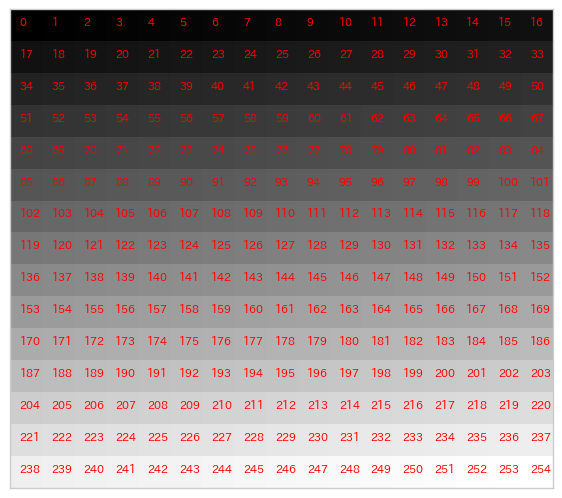

In [2]:
width = 17
height = 15
values = list(range(0, 255))
image = []
for h in range(0, height):
    _lst = []
    for w in range(0, width):
        _lst.append(values.pop(0))
    image.append(_lst)


values = list(range(0, 255))
plt.figure(figsize=(7, 7))
plt.imshow(image, cmap='gray')
for h in range(height):
    for w in range(width):
        plt.text(w-0.2, h, values.pop(0), color='red', fontsize=8)

plt.tick_params(
    labelbottom=False, labelleft=False, 
    labelright=False, labeltop=False
)
plt.grid();

イメージは掴めましたでしょうか？

黒の方が値が小さい理由は、調べた事が無いので想像ですが、恐らく光の反射の強さを表す為だと思います。

<br><br><br>

## **DTM（Digital Terrain Model）とは**
---
**`DTM（Digital Terrain Model : 数値地形モデル）`** とは、**地形の高さを表すRasterData**の事で、"DEM（Digial Elevation Model）" と表記される場合もあります。似た名前のデータで **`DSM（Digital Surface Model : 数値表層モデル）`** というデータもあります。

国土地理院の基盤地図情報ダウンロードサービスでもこのDTMは公開されていますが、全国を網羅しているのは10mメッシュ（格子の大きさ）だけです。5mメッシュや、最近では1mメッシュのデータも公開され始めていますが、まだまだ整備は進んでいません（2024-05現在）。航空機やドローンに搭載したLidarであればもっと詳細な地形のデータを取得する事が可能です（地面までレーザーが届けば）。

しかしLidarで取得した点群データには、地形の点だけが保存されている訳ではありません。そして点には当たった物体のラベルが記録されている訳でもありません。

まずはデータを見ていきましょう。

In [3]:
workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': FILE_PATH
        }
    ]
}
pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

df = pipeline.get_dataframe(0)
print(f"保存されている要素: \n{df.columns}")

保存されている要素: 
Index(['X', 'Y', 'Z', 'Intensity', 'ReturnNumber', 'NumberOfReturns',
       'ScanDirectionFlag', 'EdgeOfFlightLine', 'Classification', 'Synthetic',
       'KeyPoint', 'Withheld', 'Overlap', 'ScanAngleRank', 'UserData',
       'PointSourceId', 'GpsTime', 'Red', 'Green', 'Blue'],
      dtype='object')


様々な要素が記録されていますが、どの様な値が入力されているのでしょうか、要約統計量を見てみます。

不要な情報は少ない方が良いので、一意な値が1種類しかない列（つまり情報が使えない）は削除してから、要約統計量を計算します。

In [4]:
del_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        del_cols.append(col)

df.drop(del_cols, axis=1).describe()

X             Y             Z     Intensity           Red  \
count  6.684581e+06  6.684581e+06  6.684581e+06  6.684581e+06  6.684581e+06   
mean  -3.484883e+03  3.786842e+04  3.154098e+02  1.676435e+02  2.039356e+04   
std    2.881643e+02  2.167067e+02  6.870297e+01  6.171454e+01  8.347706e+03   
min   -4.000000e+03  3.750000e+04  1.428500e+02  0.000000e+00  5.140000e+02   
25%   -3.731850e+03  3.768077e+04  2.672600e+02  1.340000e+02  1.310700e+04   
50%   -3.475220e+03  3.786558e+04  2.959000e+02  1.790000e+02  1.927500e+04   
75%   -3.233750e+03  3.805521e+04  3.566900e+02  2.120000e+02  2.698500e+04   
max   -3.000000e+03  3.825000e+04  5.196200e+02  2.550000e+02  6.553500e+04   

              Green          Blue  
count  6.684581e+06  6.684581e+06  
mean   2.492939e+04  2.461110e+04  
std    6.574588e+03  5.020807e+03  
min    7.196000e+03  1.799000e+03  
25%    1.927500e+04  2.081700e+04  
50%    2.415800e+04  2.364400e+04  
75%    2.981200e+04  2.775600e+04  
max    6.553500e+04  6.553500e+04

出力したデータを見てみると、**「X（横座標）」「Y（縦座標）」「Z（高さ）」「Intensity（反射強度）」「Red（赤色の強さ）」「Green（緑色の強さ）」「Blue（青色の強さ）」** だけでした。ちなみにこの色情報の最大値は2の16乗の範囲内なので16bitの色情報だと推測できます。

反射強度について分析した事が無いのでアレですが、これでは地表の点を抽出する事は出来ない様に思えます。

では、どのようにして **「地表点か、それ以外か」** の分類を行うのでしょうか。
<br><br><br>

## **CSF（Cloth Simulation Filter）による点群分類**
---
PDAL の filters 関数には様々なクラスタリング方法がありますが、今回は **`CSF（Cloth Simulation Filter）`** を使用して「地表点か、それ以外か」を分類する方法について、簡単に解説していきます。

実務で点群データを扱う場合「地表点か、それ以外か」に分類する事は非常に重要なタスクです。クラスを分ける事で、DTM や DSM を作成する事が出来ますし、その間にある点群は内部の構造を表していると考える事も出来ます。

CSF は点群の上下を反転させそこに仮想 Cloth（布）を落下させる物理プロセスをシュミレーションする事により、点群の中から地表点とそれ以外の点に分類しフィルタリングを行います。

### 1. **データのイメージ**
詳細を確認する前に、まずは全体として、どの様な流れで DTM を作成するのかを見ていきましょう。

以下の画像は Lidar でデータを計測した場合のイメージです。

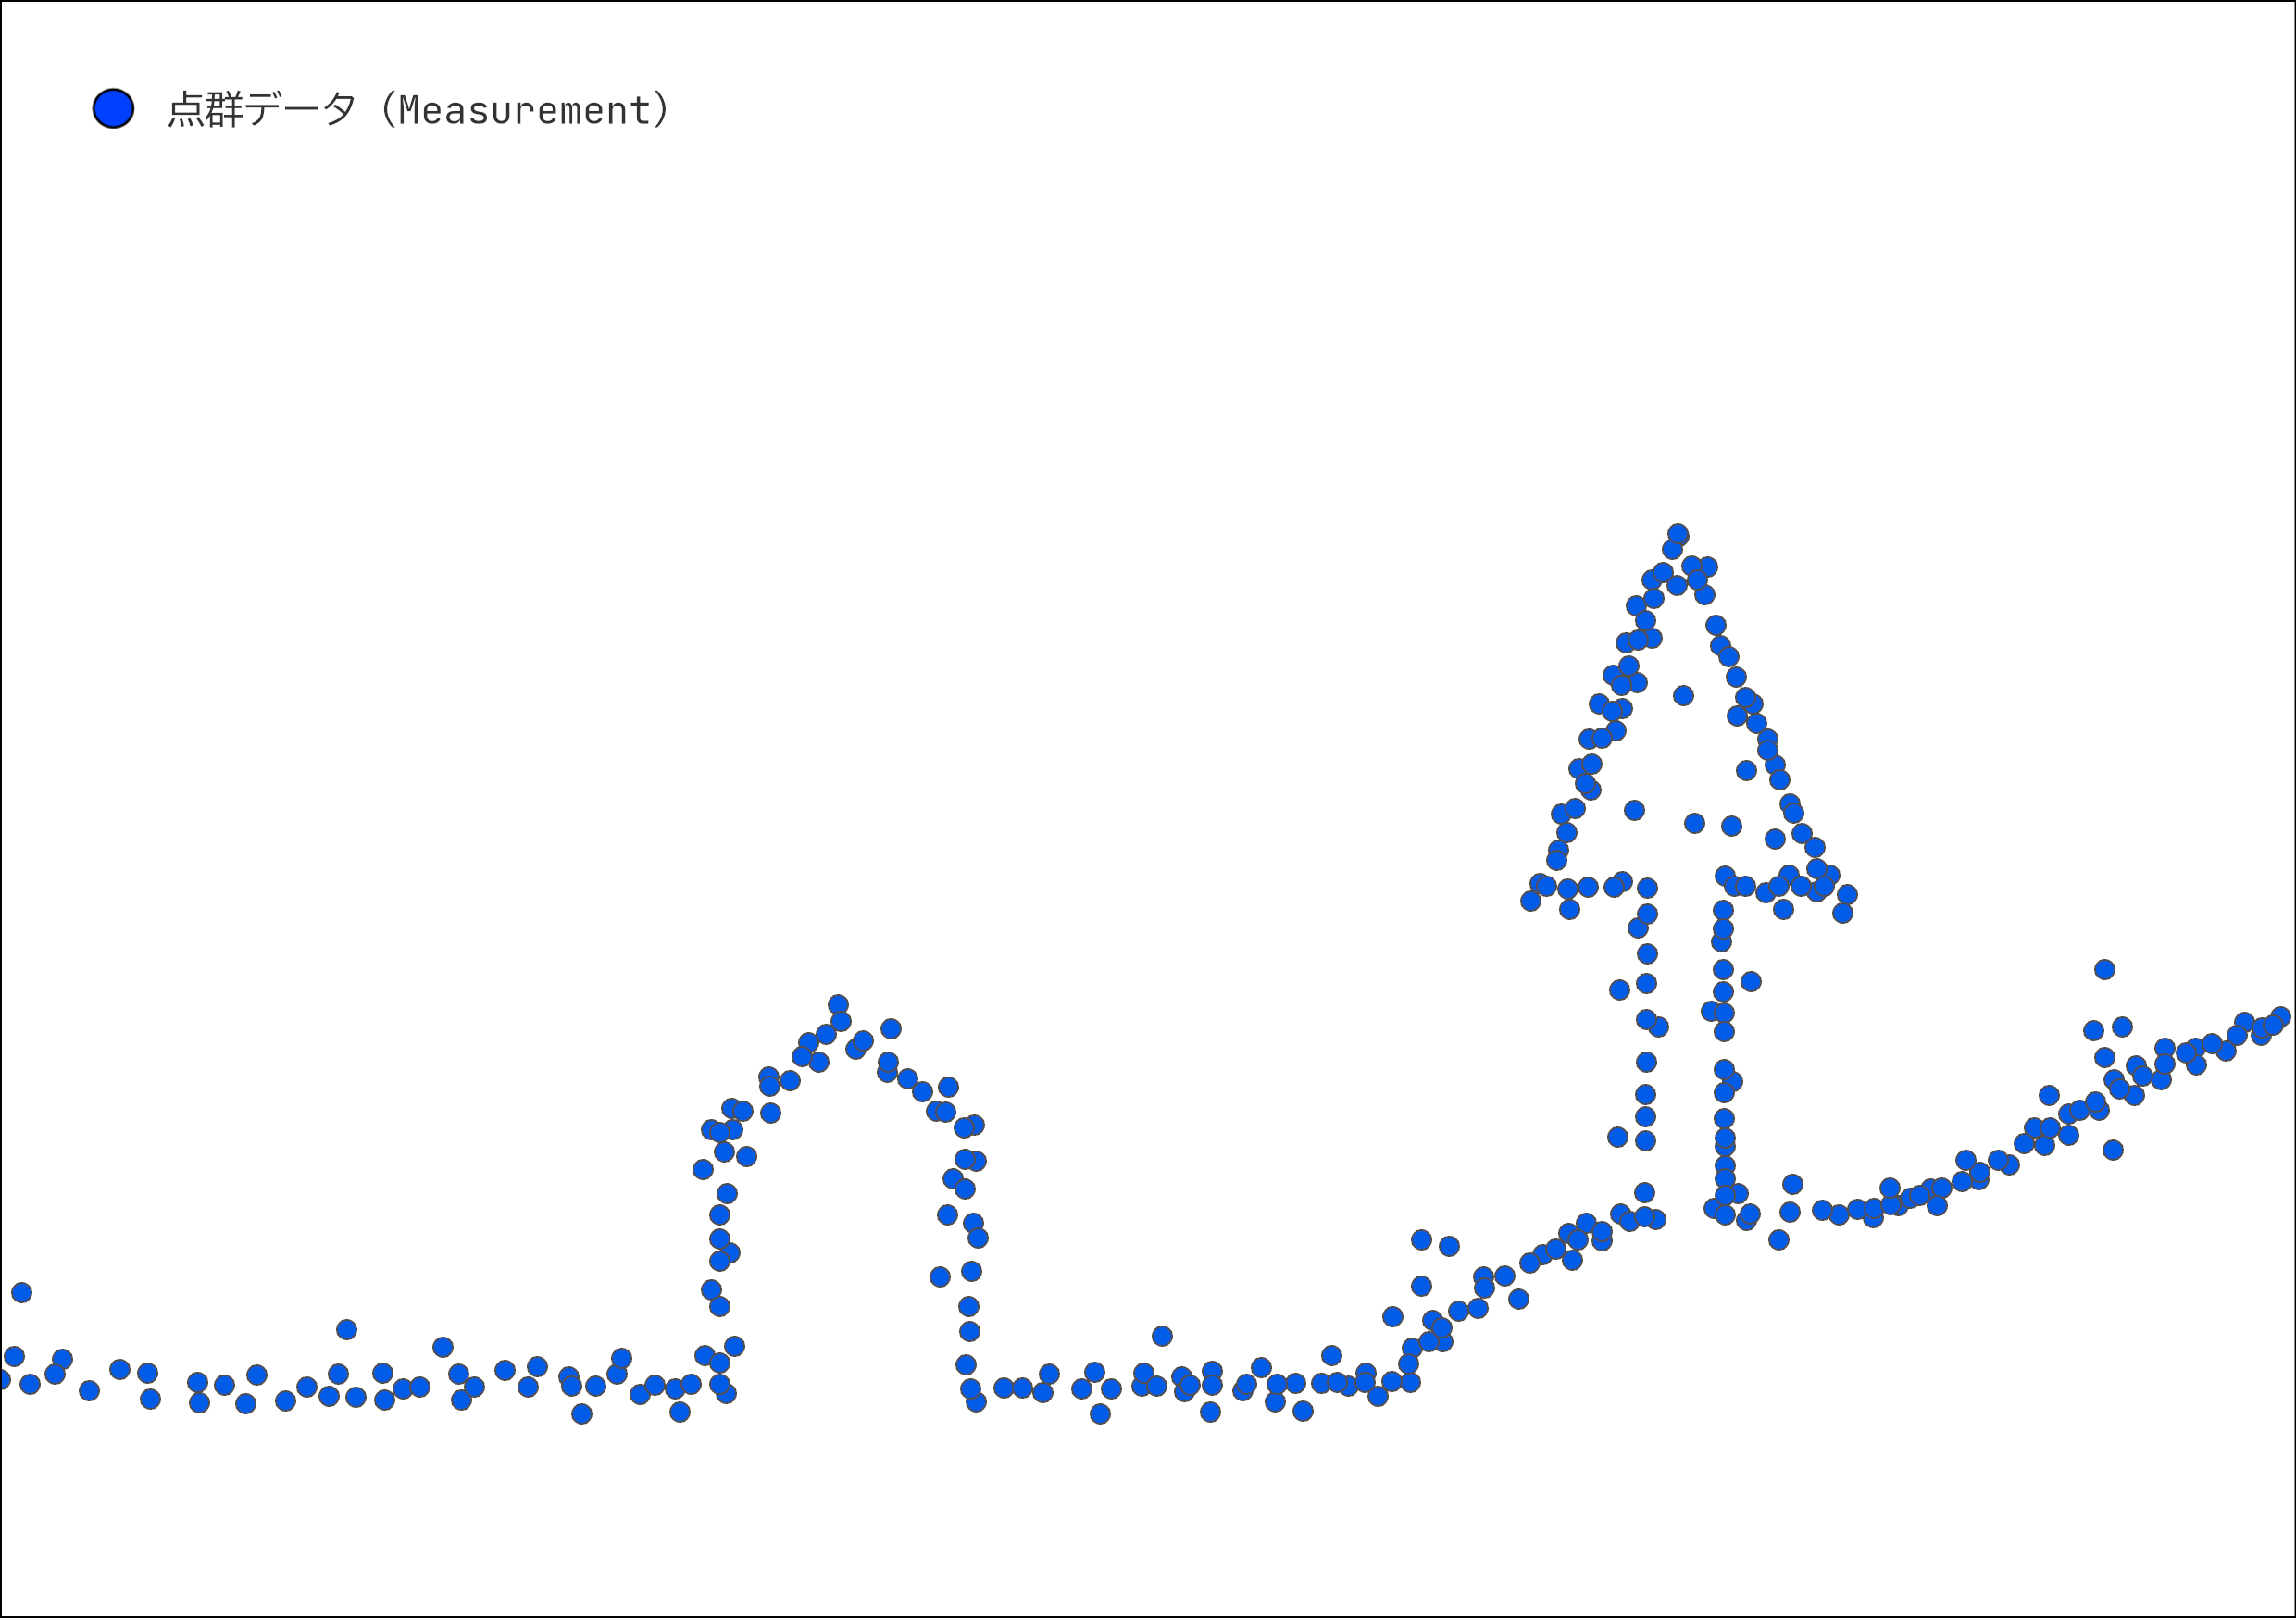

In [27]:

display_width = 700

Image(r'../images/IMG_01_Measurement.png', width=display_width)

### 2. **計測データの反転**
計測したデータの上下を反転させます。データには建物や樹冠、地面などの表面に当たり、反射したものが記録されています。このデータの上下を反転させ、ある断面を見てみると、地物に当たった場所は凸から凹みに変わっているはずです。

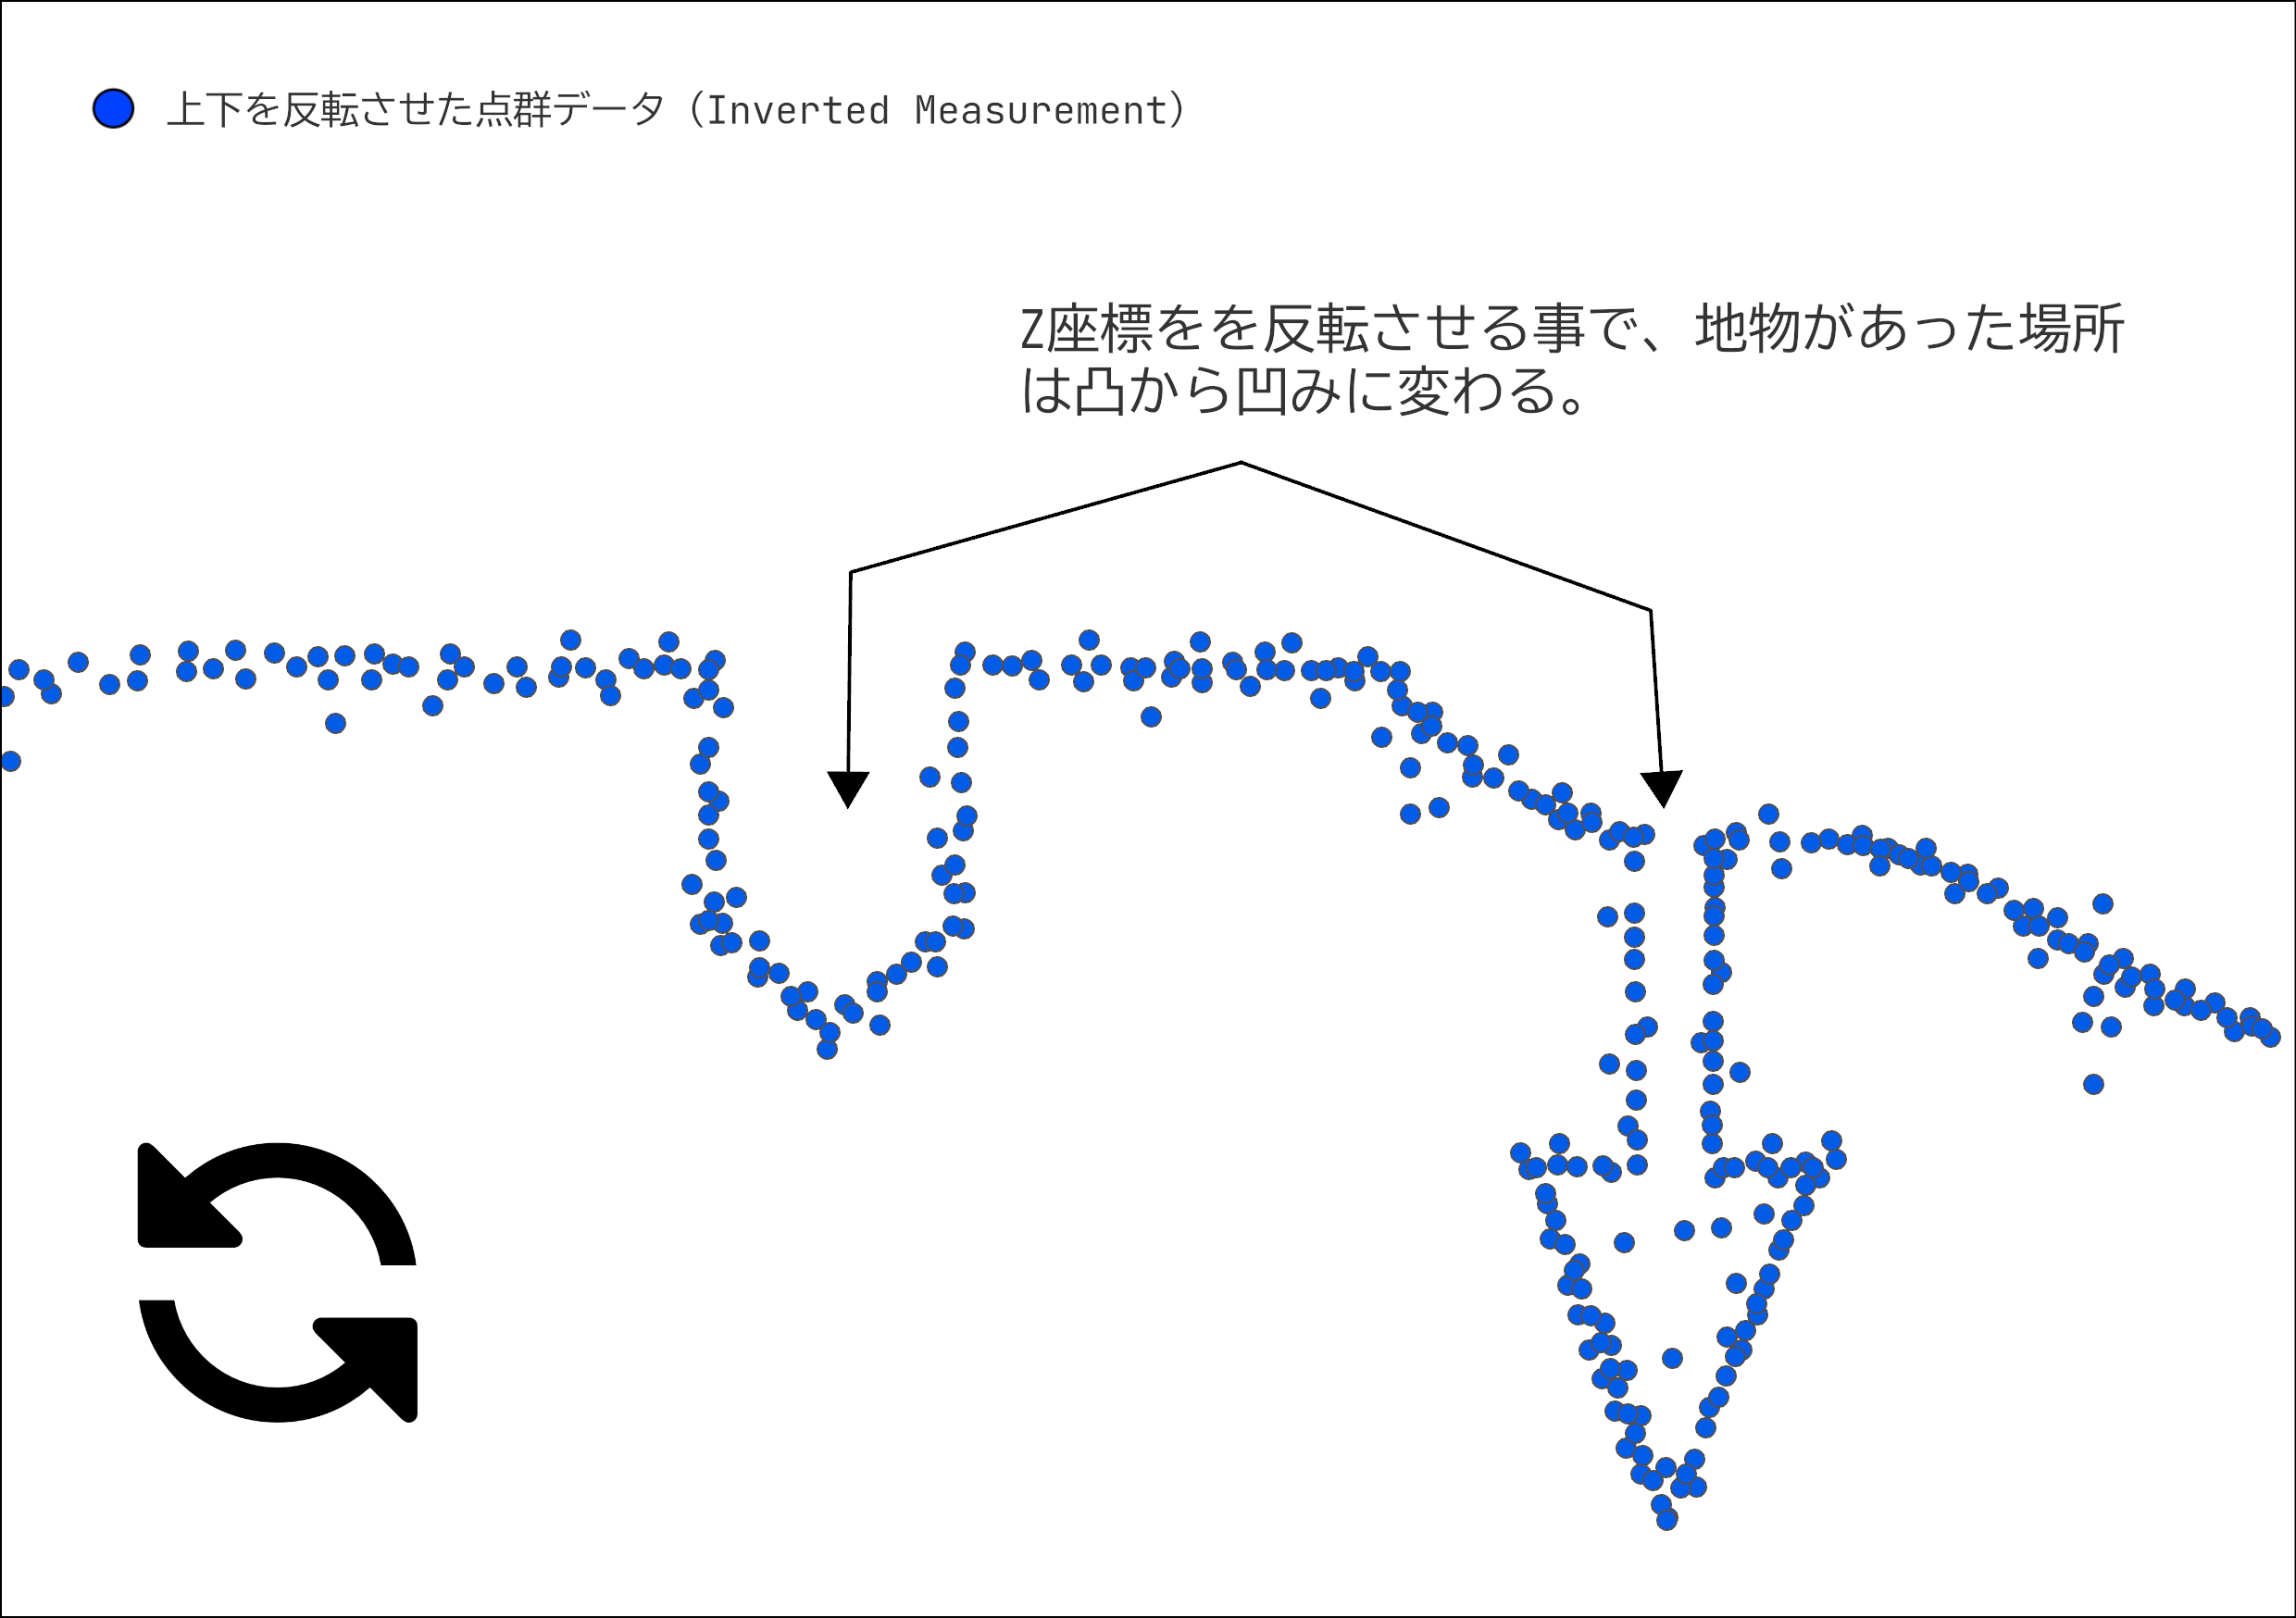

In [6]:

Image(r'../images/IMG_02_InverseData.png', width=display_width)

### 3. **クロスシュミレーション**

反転したデータに対して、Cloth を置きます。Cloth が重力で落下し、反転した点群の上に覆いかぶさるようなイメージです。

Cloth の硬度をハンカチ程の柔らかさだと仮定すると、その Cloth は表面を撫でる様にぴったりと反転した地表面にくっついているはずです。また、Cloth のノードよりも小さな凹みには Cloth は落ちていきませんし、柔らかな Cloth は地形の変化に対応し、その形を変えます。この Cloth の形状は、最終的には地形の形を表す DTM となります。

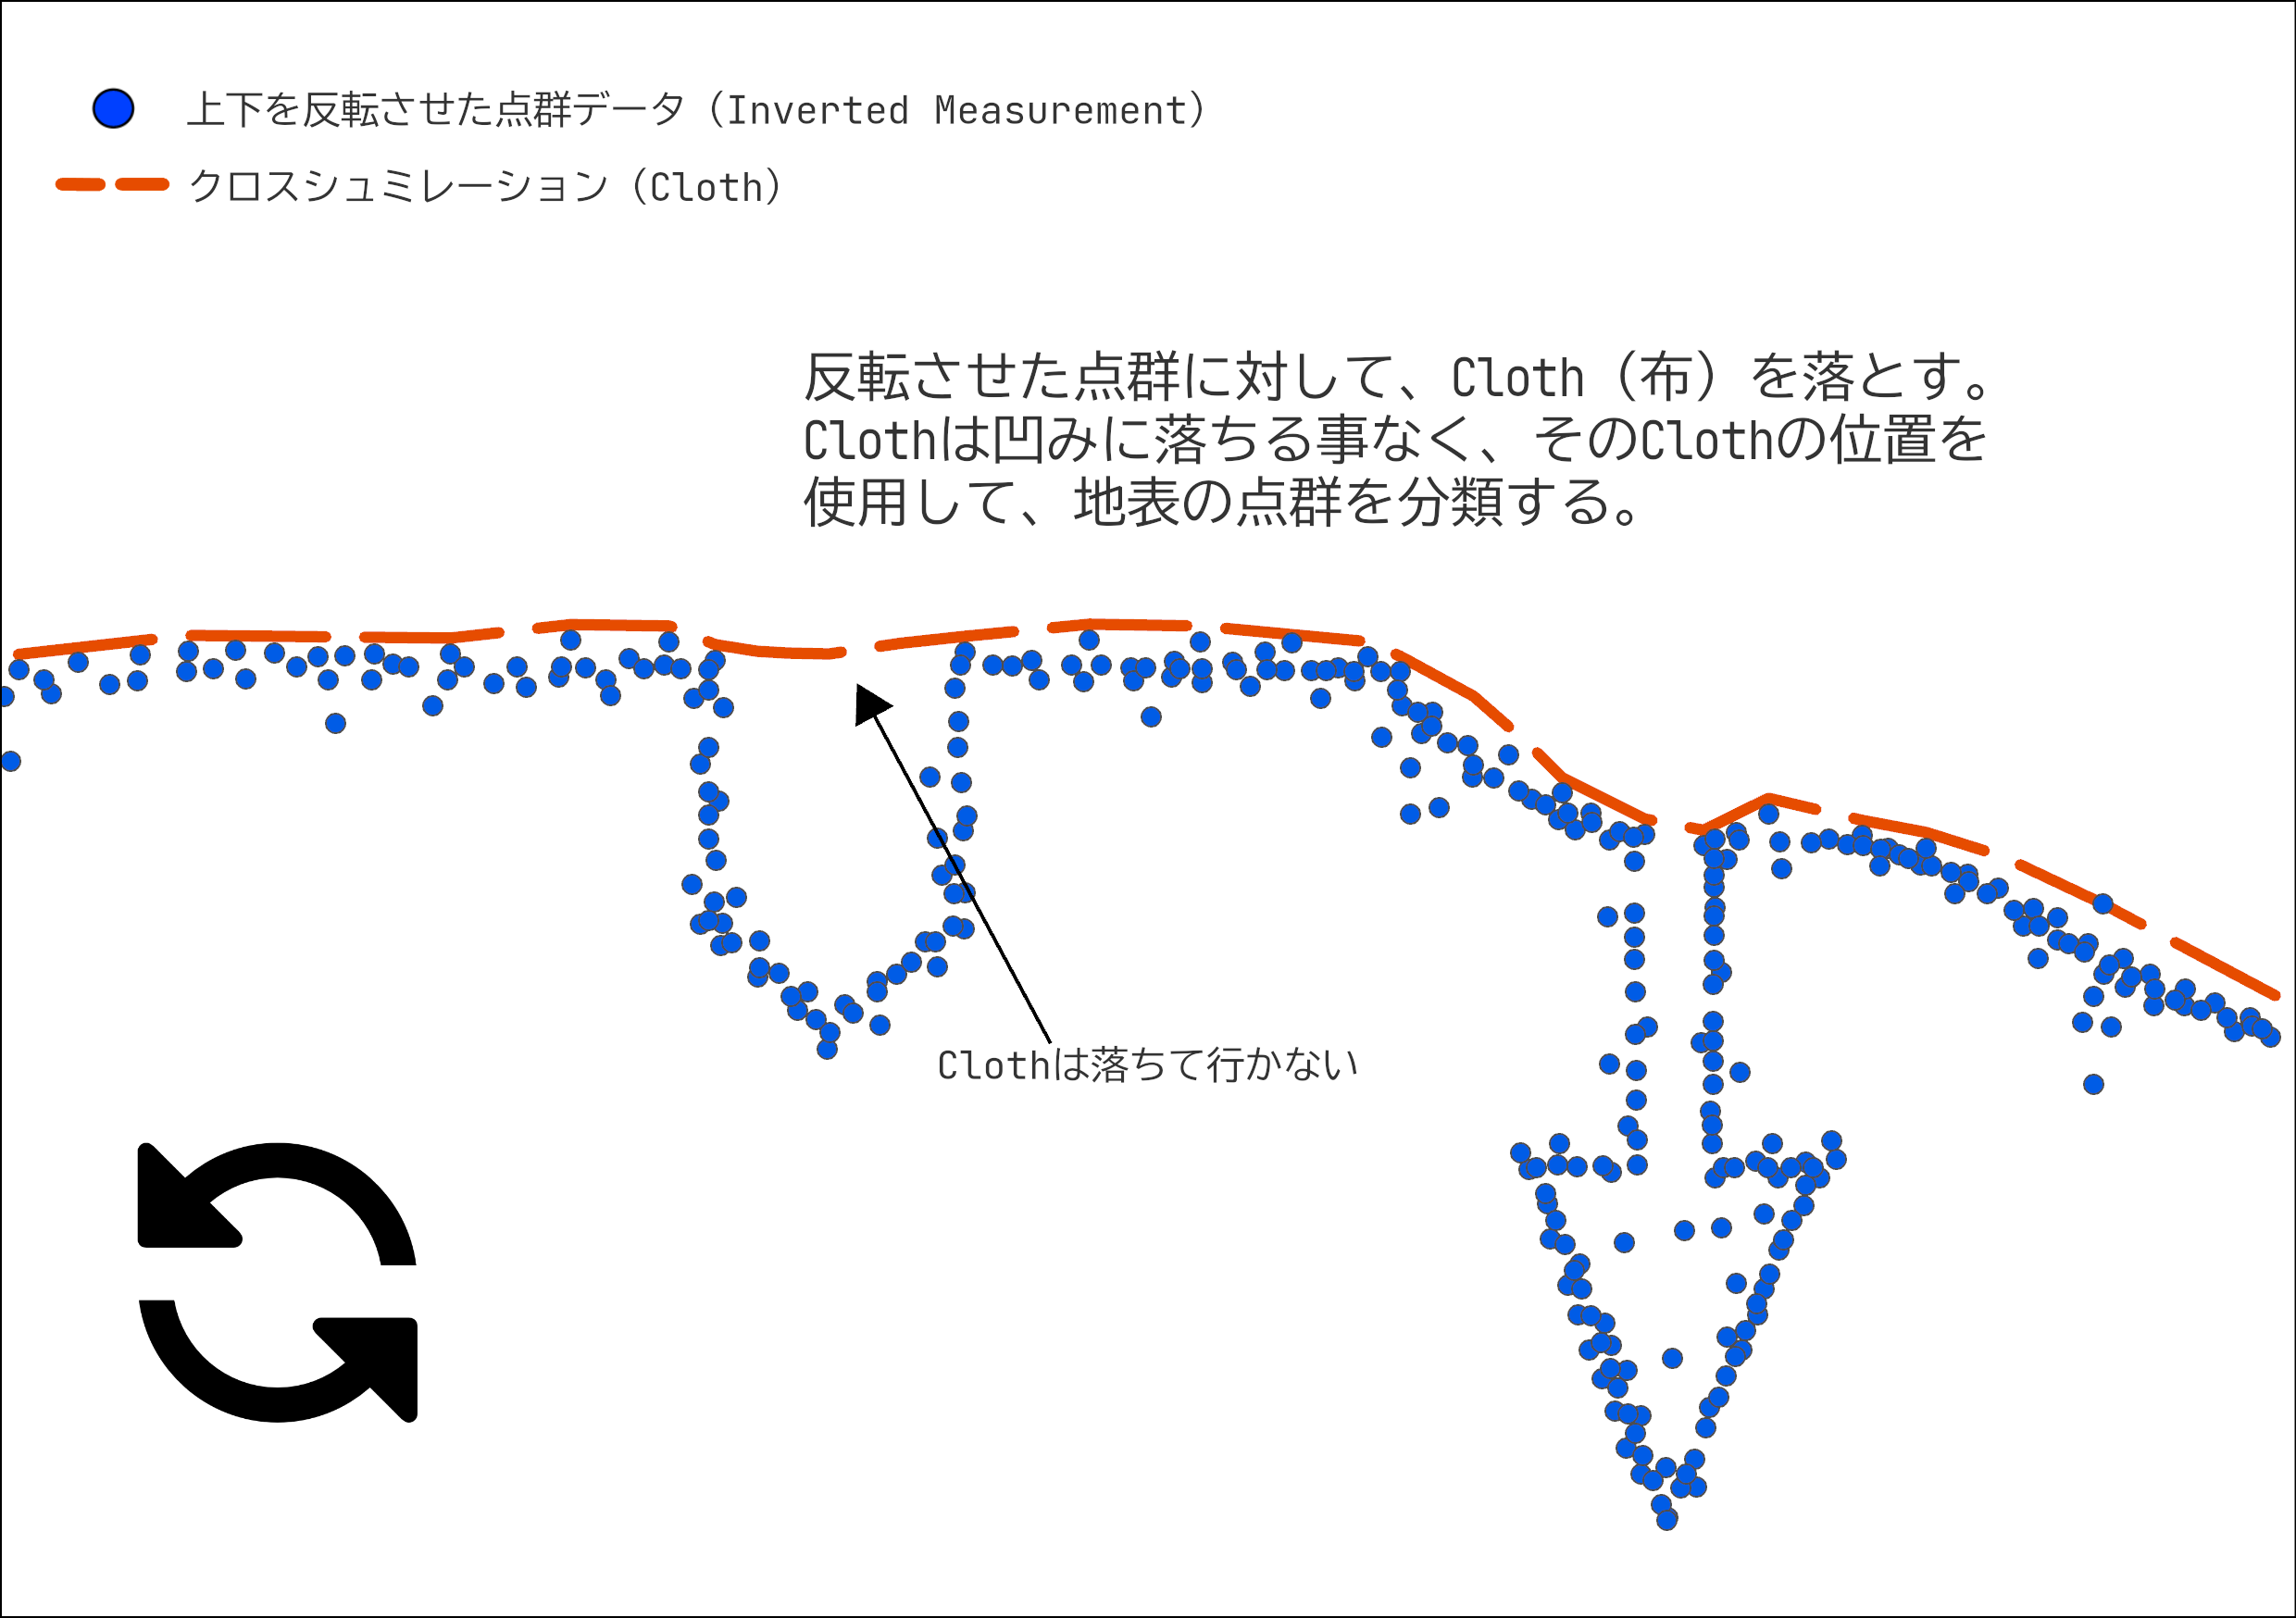

In [7]:

Image(r'../images/IMG_03_ClothSimulation.png', width=display_width)

<br><br><br>
## **CSFの詳細**
---
上記で CSF の流れをイメージできましたか？ここからはもう少し中身を掘り下げて、実施手順と重要なパラメーターについて解説していきます。

### **Grid Particle の作成**
設定した **"GR（Grid Resolution : グリッド解像度）"** に従って **"Particle（粒子）"** の数（Particle同士の距離）を決定します。"PDAL" の CSF ではこの初期値が $resolution = 1.0$ で設定されています。

Clothは、質量と相互接続性を持つ Particle で構成されるグリッドとしてモデル化する事ができます。これまでは Cloth という書き方をしてきたのですが、個人的には「布」というより「網」の方がよりイメージがしやすいのではないか？と考えています。網は紐が交わる部分に結び目の玉があるので、結び目の玉がParticleという感じで個人的にはイメージしています。

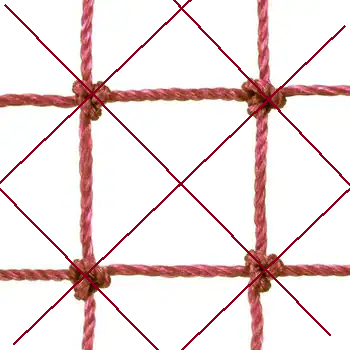

In [8]:

Image('../images/fishing net.png')

### **CPを探す**
計測した点群データと Particle を同じ平面上に投影し、各 Particle に最も近い計測点を **"CP（Named Corresponding Point : 名前付き対応点）"** とし、CP の高さを **"IHV（Intersection Height Value : 交差点の高さ）"** に記録します。

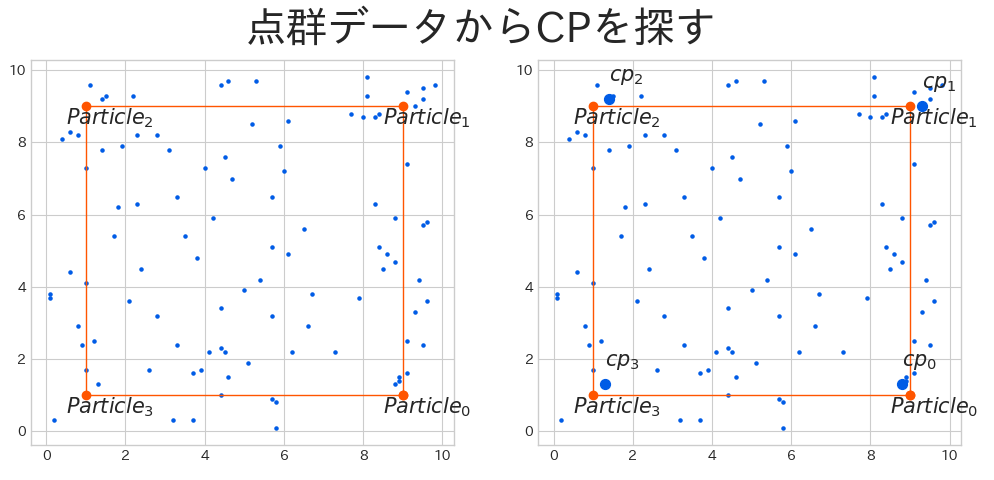

In [9]:

Image(r'../images/IMG_04_FindingCP.png', width=display_width)

### **外力による変位**
Cloth を構成する Particle は垂直方向にだけ動く事が出来ます。この Particle をまずは鉛直方向に変位させます（外力による変位）。

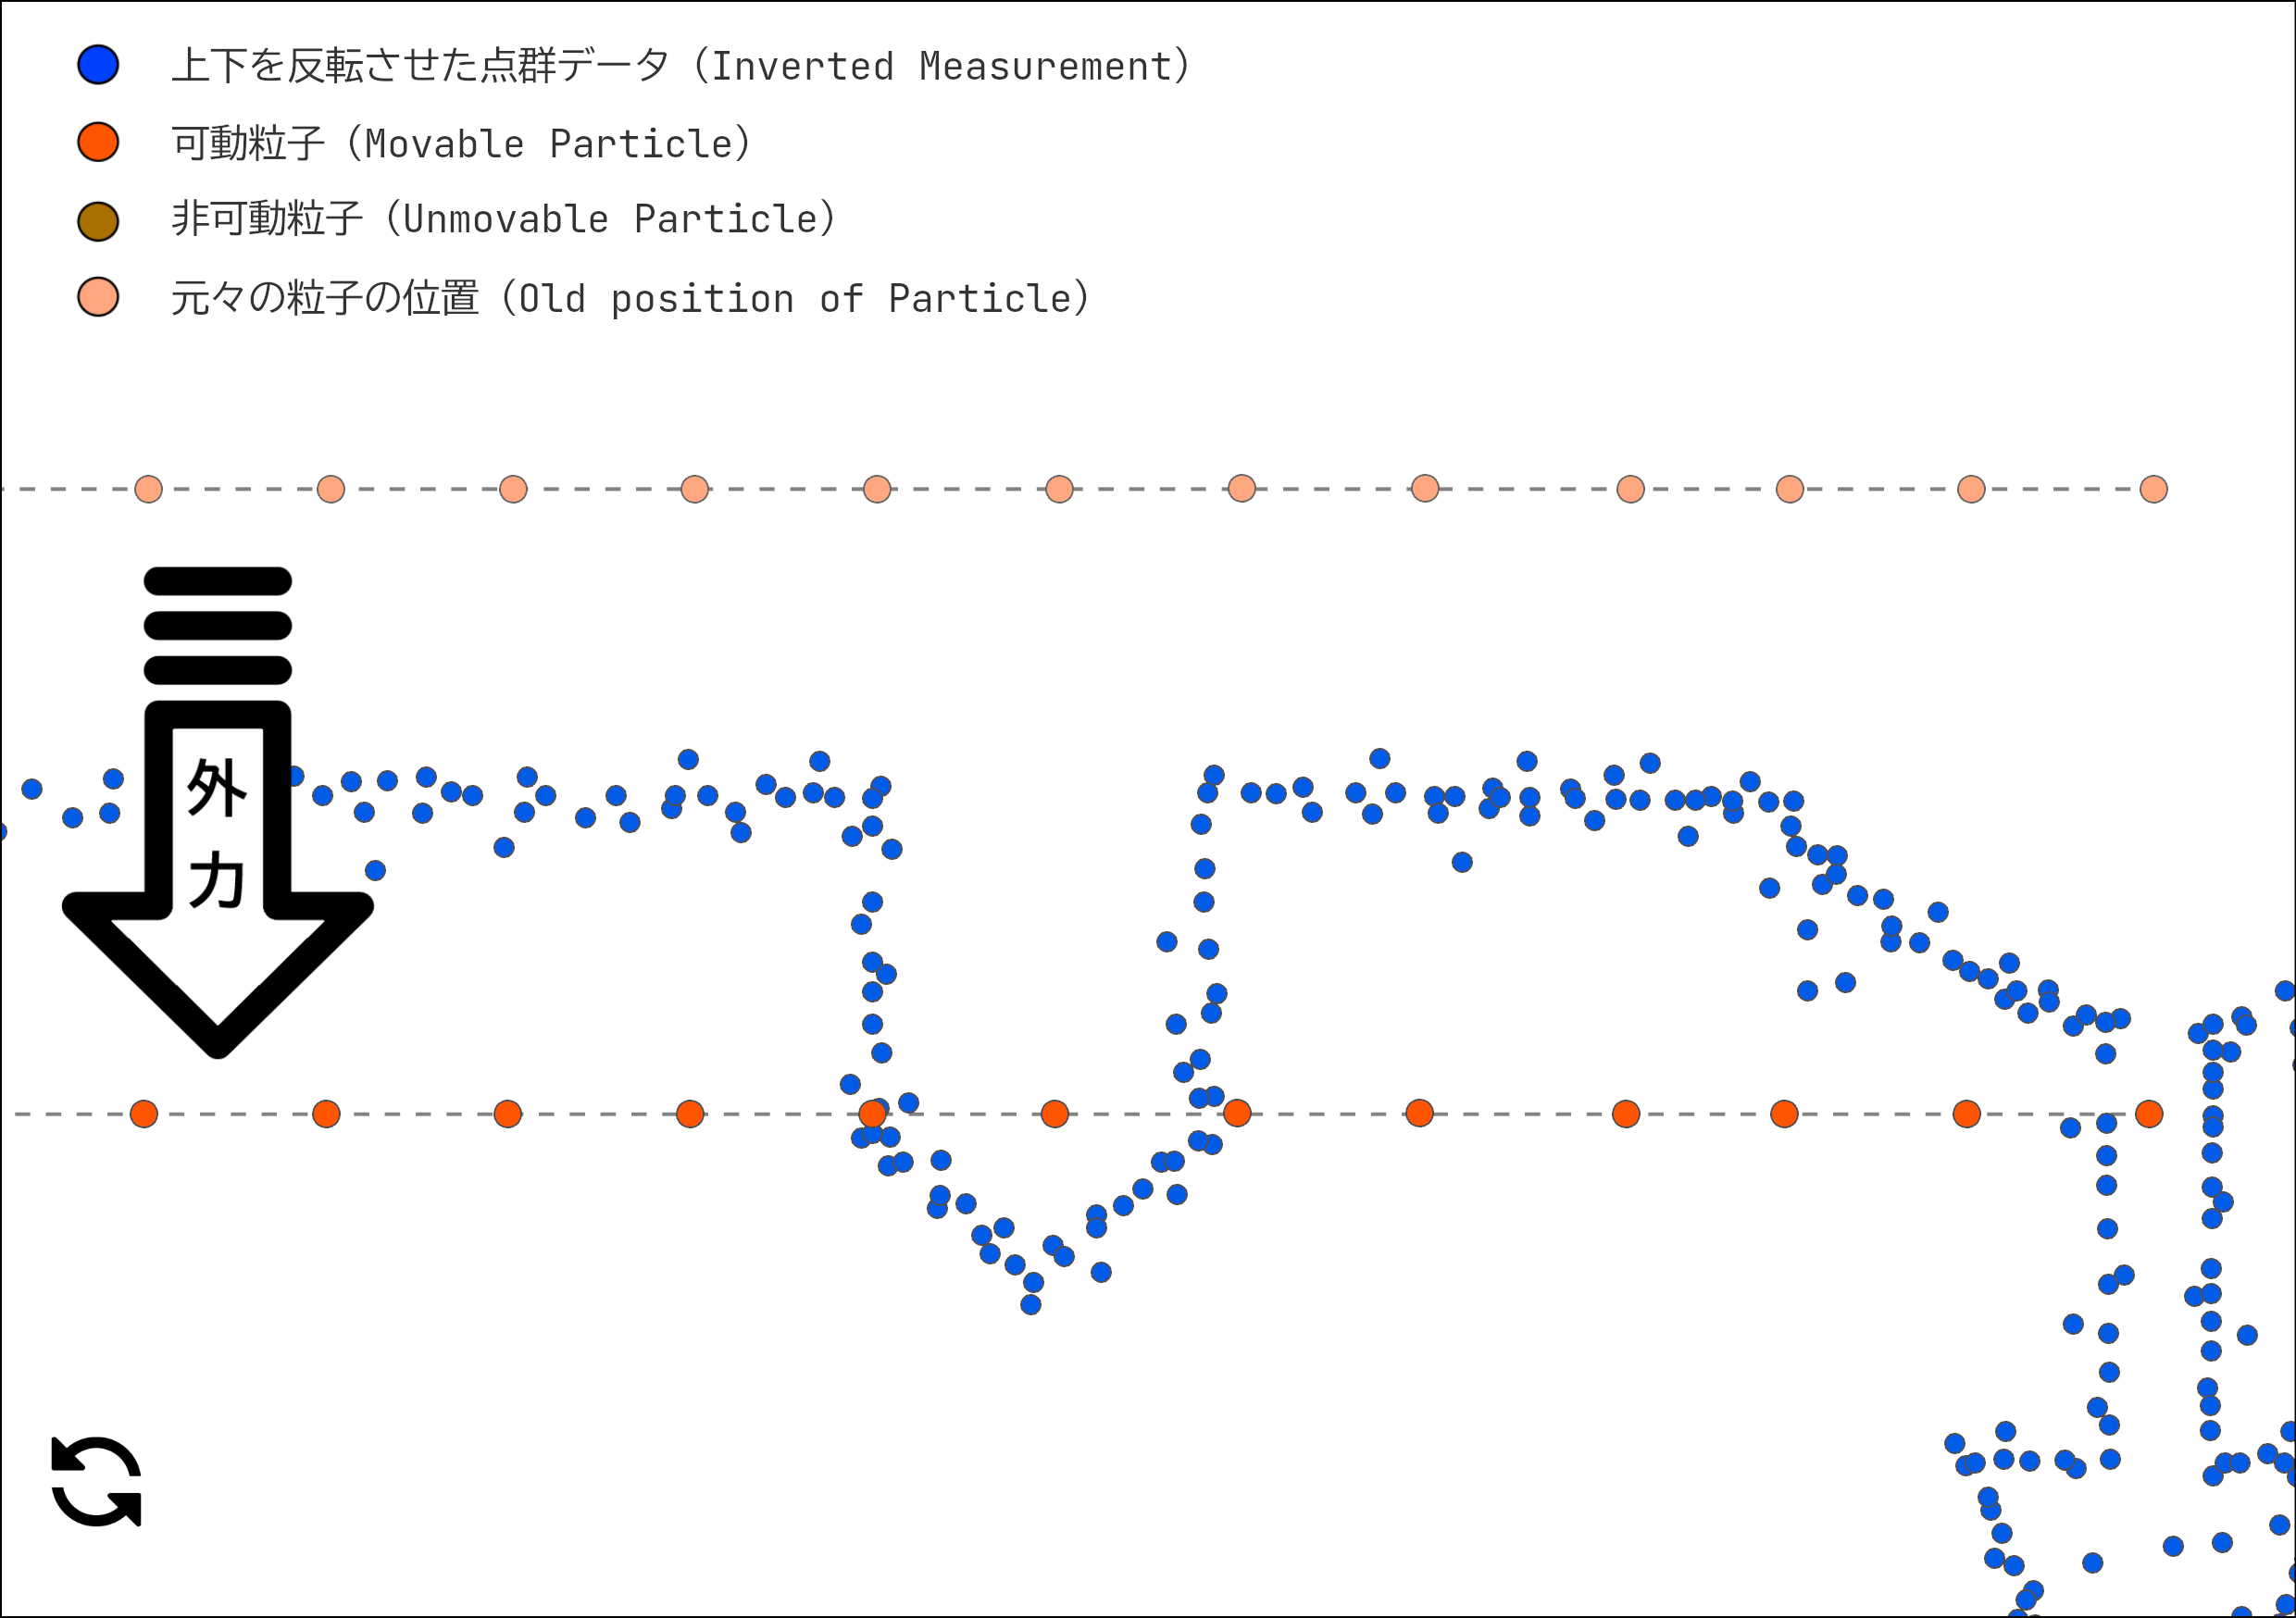

In [10]:

Image(r'../images/IMG_05_ExternalForces.png', width=display_width)

### **内力による変位**
鉛直方向に変位した Particle ですが、一部の Particle は紐づけられた CP よりも下に潜り込んでしまいます。潜り込んだ Particle は紐づけられた CP の IHV まで浮上させます。

押し戻された Particle を **"非可動粒子（Unmovable Particle）"**、そのままの位置の Particle を **"可動粒子（Movable Particle）"** として定義します。可動粒子は今後も垂直方向に移動が許可されていますが、非可動粒子は動かす事が出来なくなります。


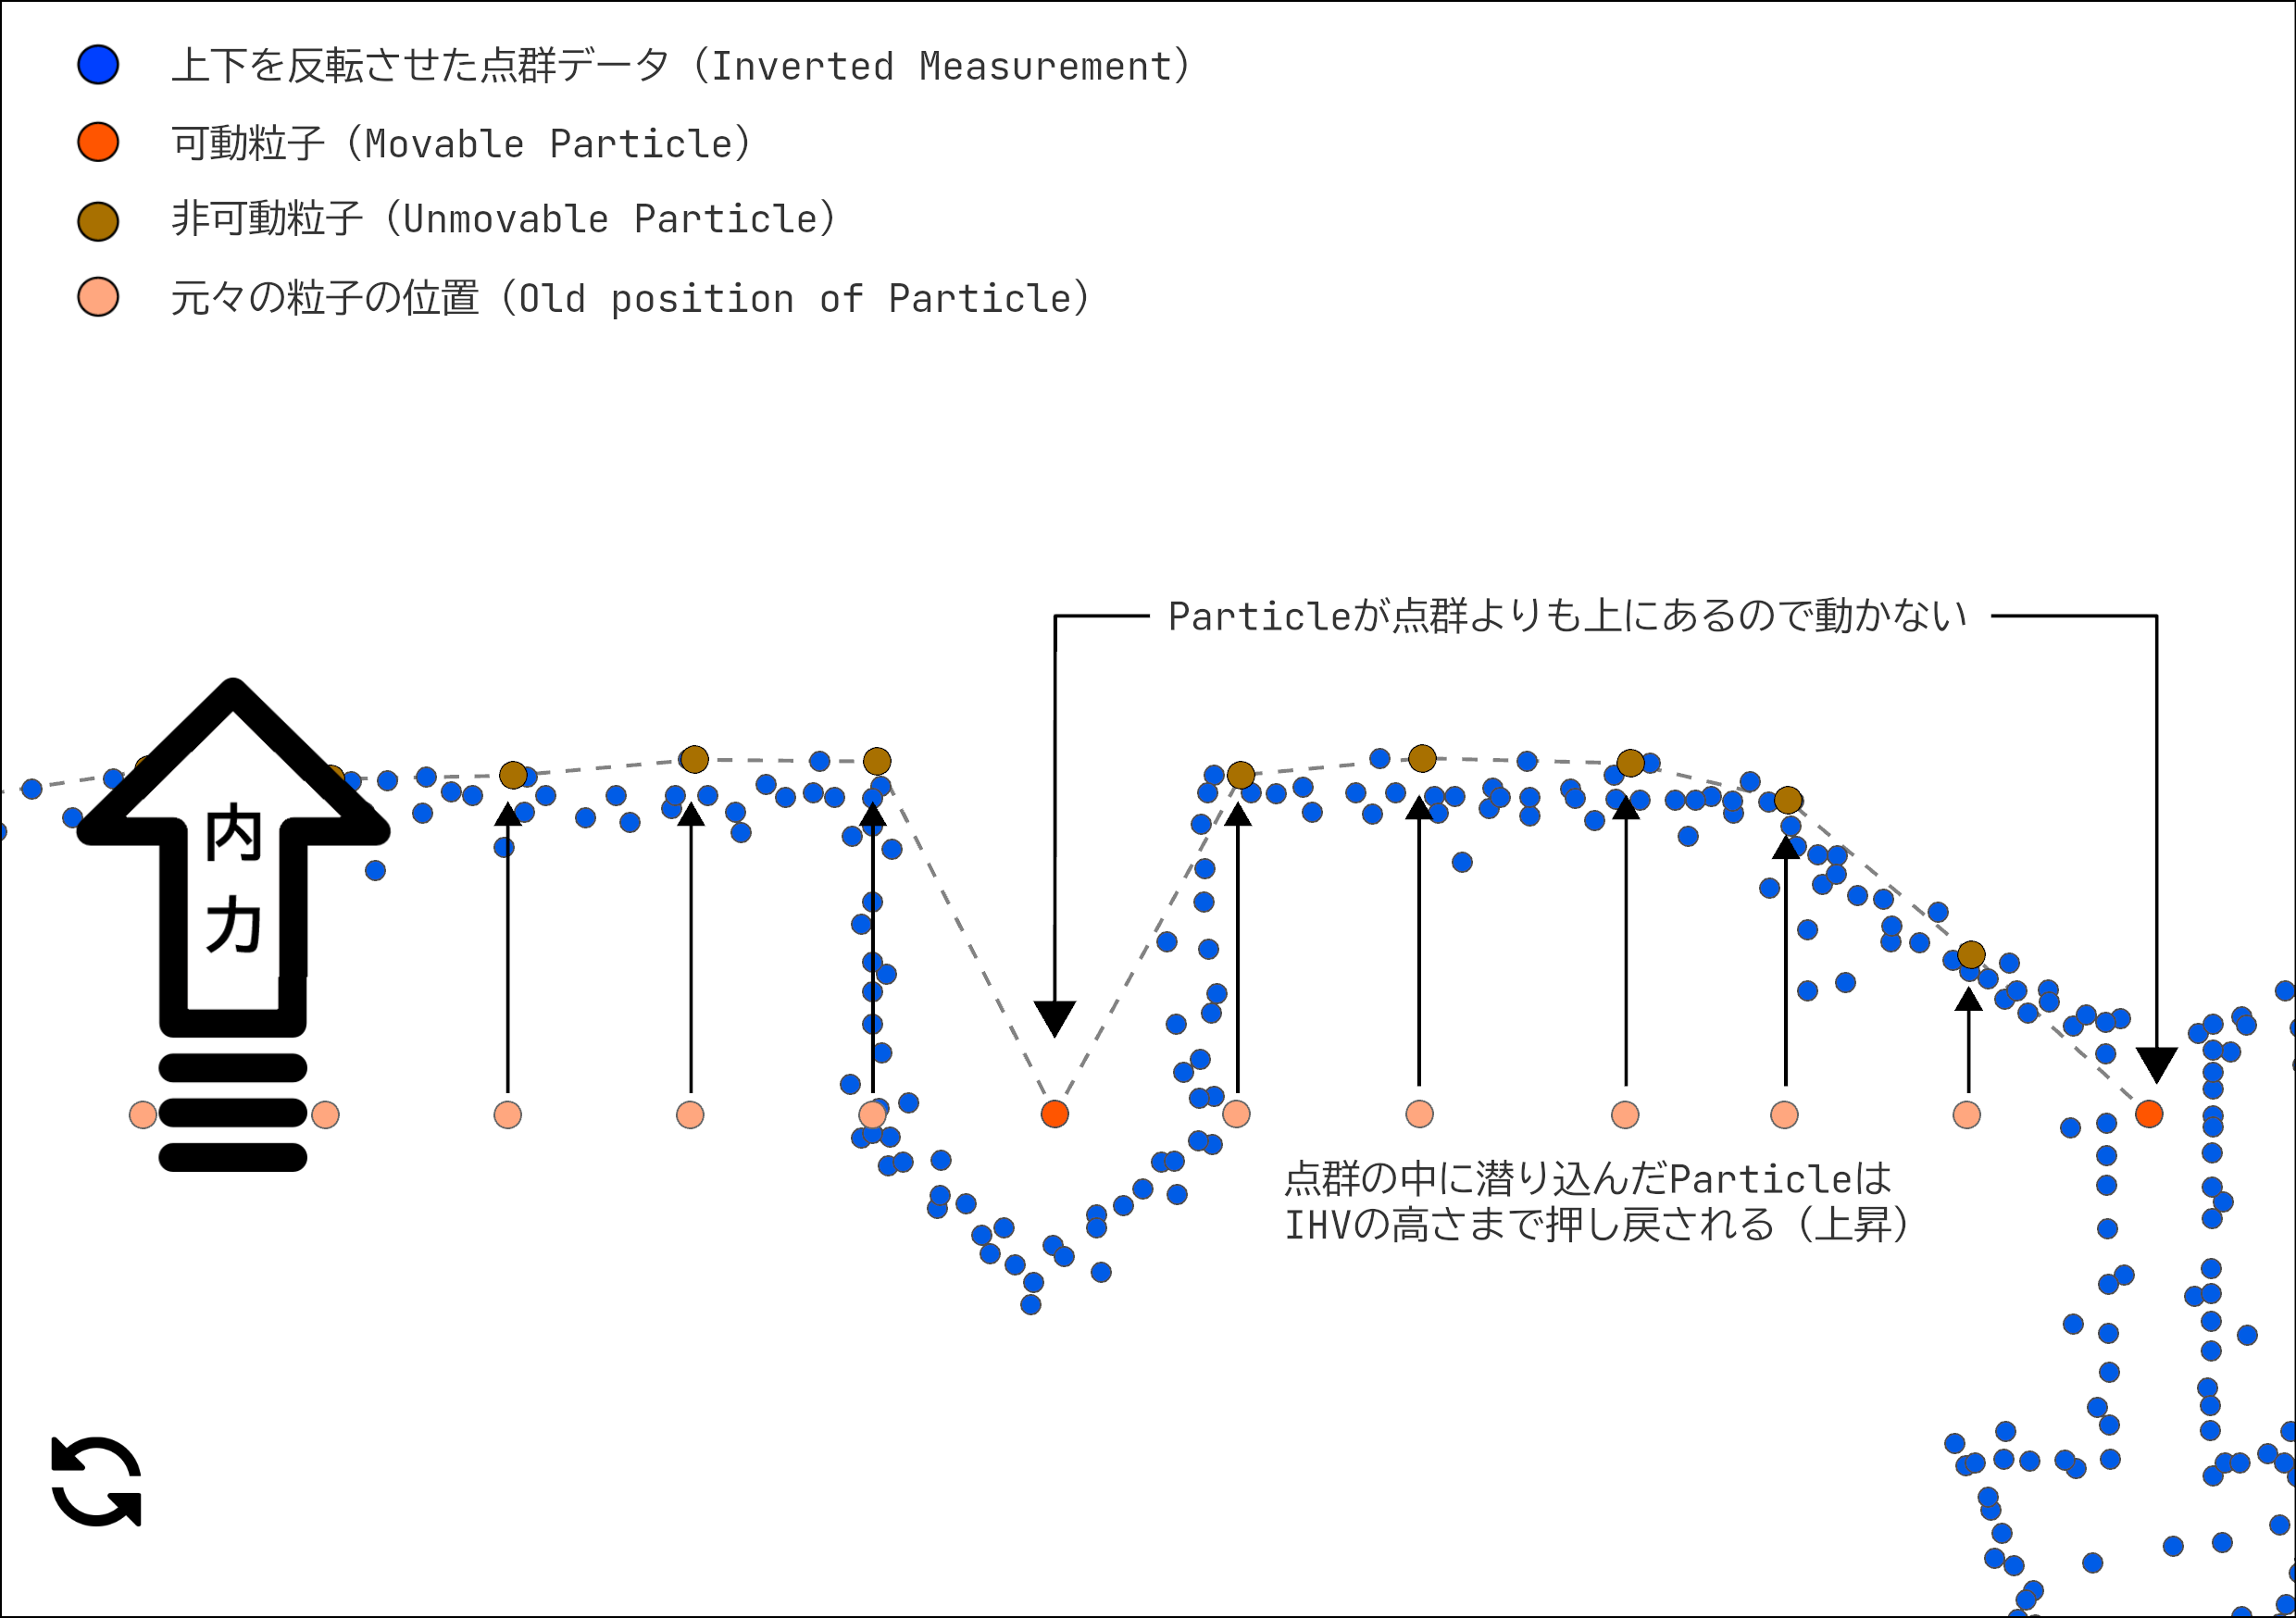

In [11]:

Image(r'../images/IMG_06_InternalForces.png', width=display_width)

### **剛性による変位**
非可動粒子は動かせなくなりましたが、可動粒子の位置はまだ決定したわけではありません。Particle には外力と内力の2つの力が働いており、相互接続された Particle は、お互いに同じ高さになろうと、引き合う力が働きます。

可動粒子同士が引き合う場合は、互いに垂直距離の半分づつ変位します。

可動粒子と非可動粒子とが引き合う場合は、可動粒子だけが非可動粒子側へ垂直距離の半分変位します。

お互いが非可動粒子だった場合は変位しません。

この工程は設定したパラメーターの **RI（Rigidness : 剛性）** で指定した回数だけ繰り返されます。

可動粒子と非可動粒子の関係で考えるならば、$RI = 1$ の場合の変位距離は垂直距離の $1/2$ 、$RI = 2$ の場合は垂直距離の $3 / 4$ 、$RI = 3$ の場合は垂直距離の $7 / 8$、$RI = 5$ の場合は垂直距離の $31 / 32$ 変位する事になります。

つまり RI を大きくすればする程、Particle は凹みの影響から逃れるように浮上し、小さくすればする程、凹みの影響を受けやすくなります。剛性を上げれば上げる程に、地物の影響を受けづらくなりますが、斜面に追従しづらくなり、急斜面が苦手になります。"PDAL" の CSF ではこの初期値が $rigidness = 3$ で設定されています。

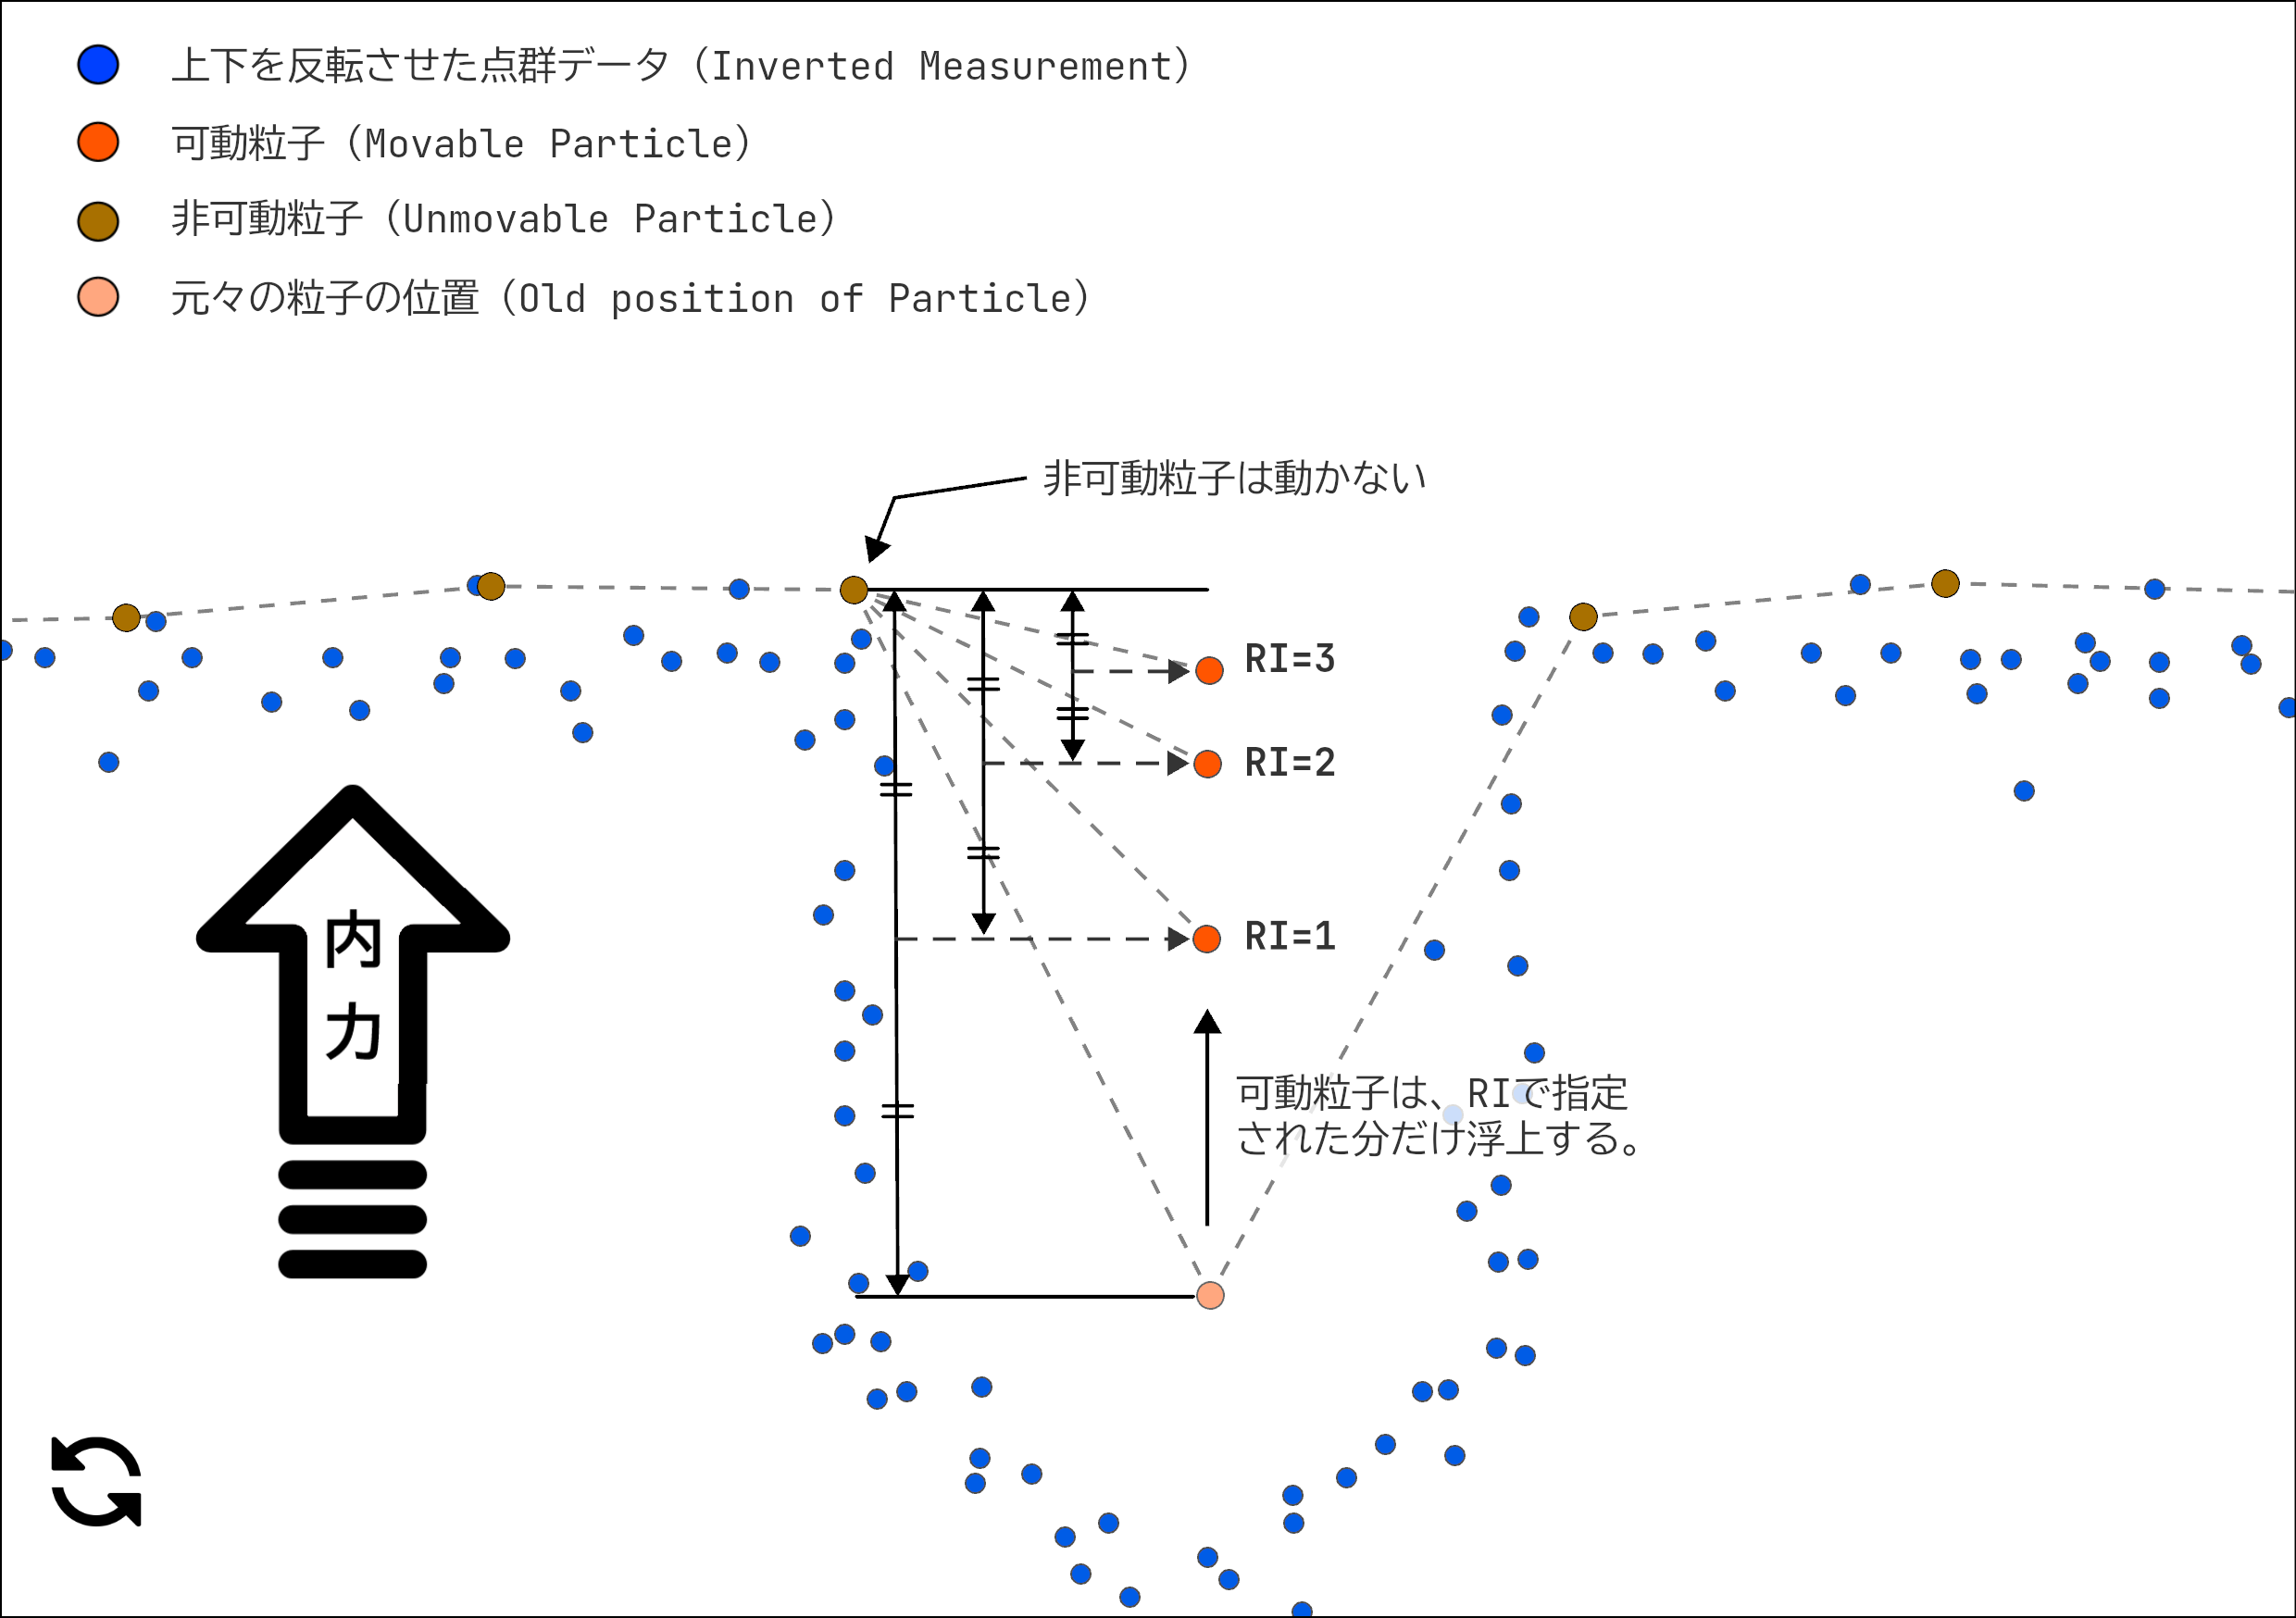

In [12]:

Image(r'../images/IMG_07_Rigidness.png', width=display_width)

### **点群分類**
充分にシュミレーションを繰り返したら、最後に地表点とそれ以外とに分類します。

シュミレーションが終了した Cloth（Grid Particle）と点群データとの距離を計算し、パラメーターとして設定されている **$h_{cc}$（Threshold）** より距離が小さな計測点は **"BE（Bear Earth : 地表点）"** 、それ以外は **"OBJ（Object : 地物）"** に分類されます。"PDAL" の CSF ではこの初期値が $threshold = 0.5$ で設定されています。

距離は `cloud-to-cloud distance computation algorithm` で計算します。気になる方はページ下の参考からどうぞ。

※画像の距離の閾値はイメージです。

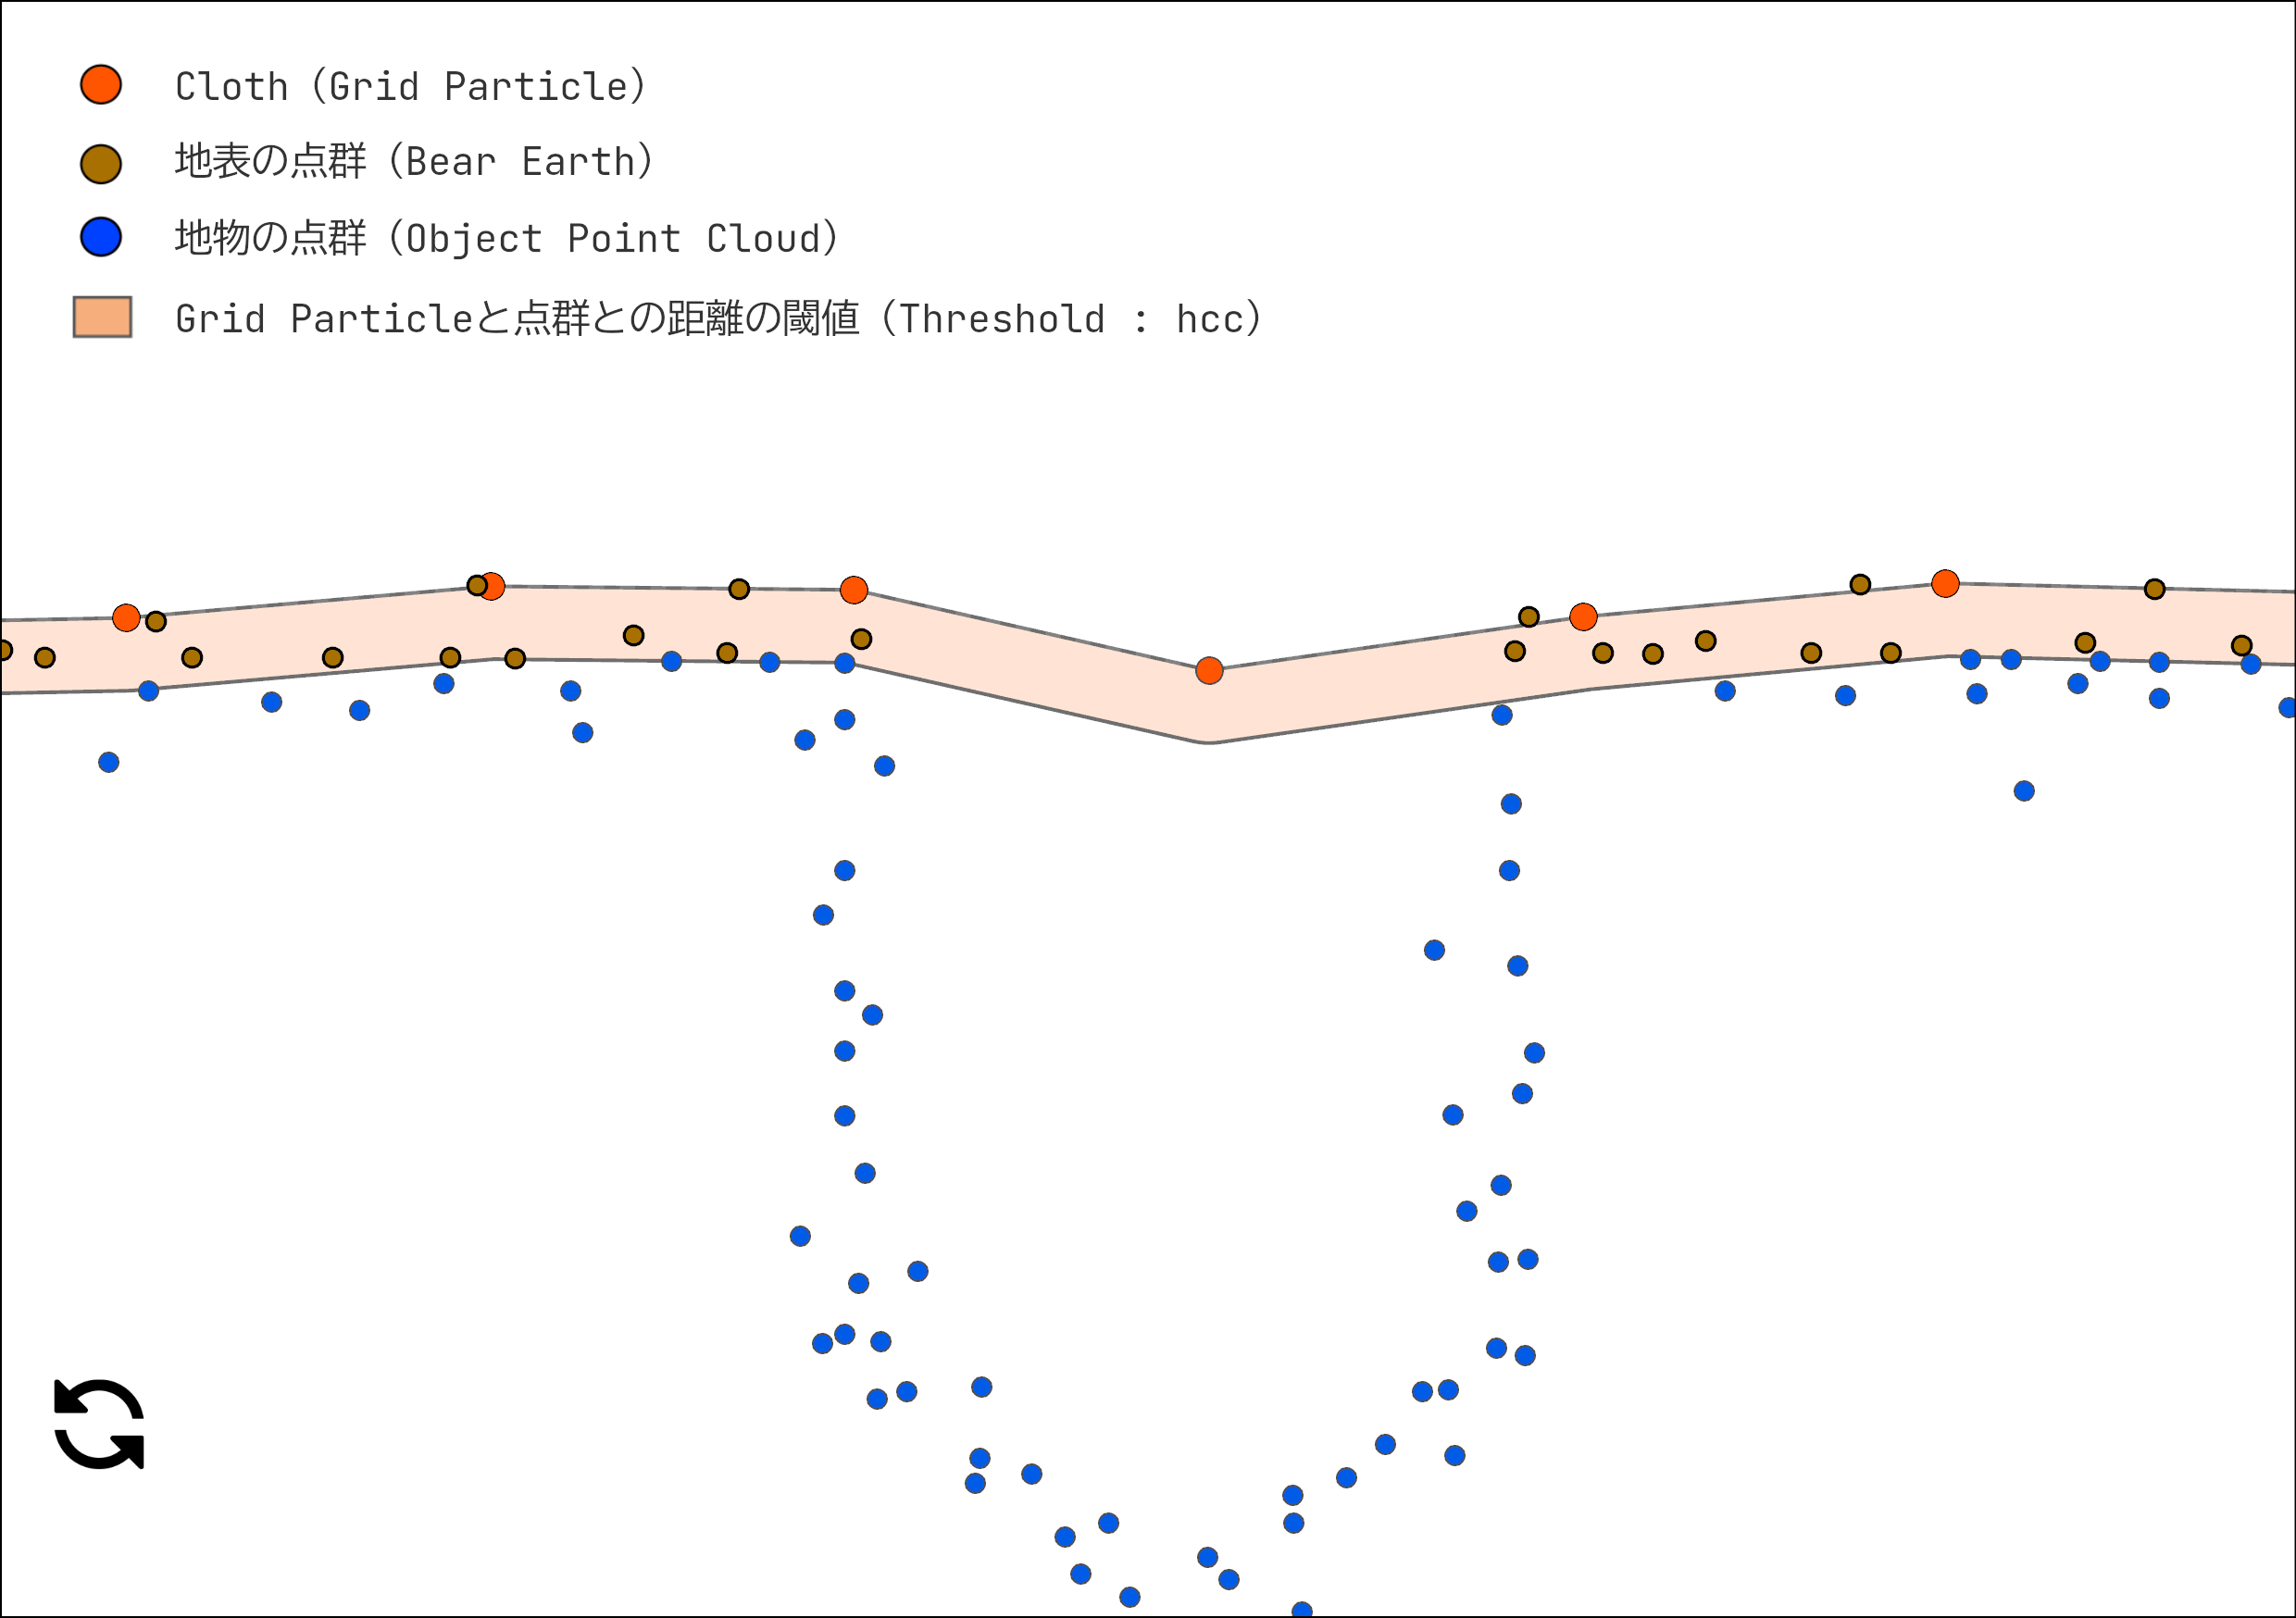

In [13]:

Image(r'../images/IMG_08_Classification.png', width=display_width)

<br><br><br>
## 実データでの検証
---
ここまでで CSF による点群データの分類方法を学んできました。実際の Lidar で計測したデータに対して CSF を実施して、点群の分類を行ってみましょう。

CSF は Pipeline のワークフローに **"filters.csf"** の辞書を追加して行います。

In [14]:
workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': FILE_PATH
        },
        {
            'type': 'filters.csf',
            'resolution': 1.0,
            'rigidness': 3,
            'threshold': 1
        }
    ]
}
pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()
df = pipeline.get_dataframe(0)

全体のデータを見てもよくわからないので、サンプルを取り出して、断面図を見てみましょう。

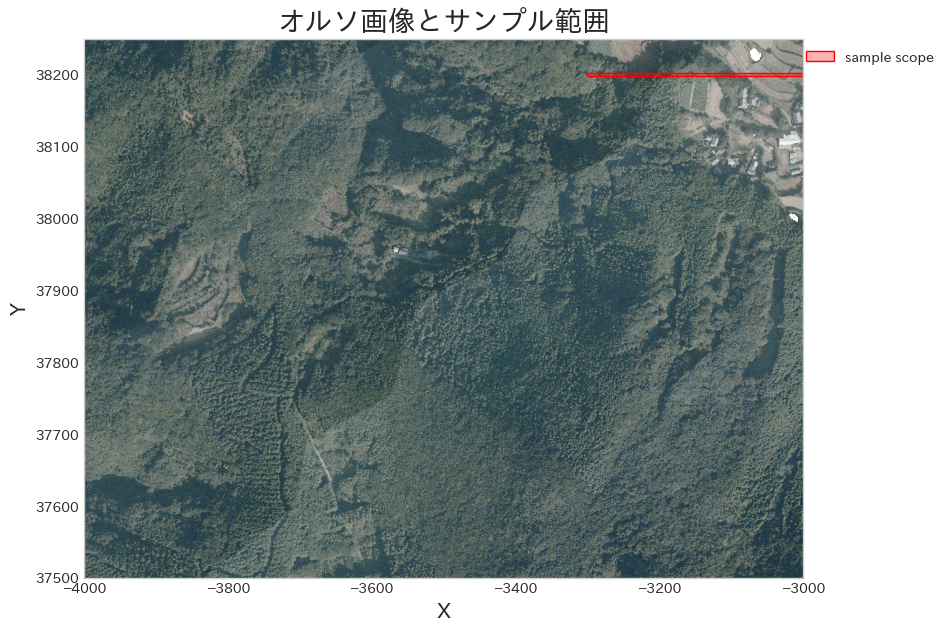

In [15]:
# 点群データ全体の範囲を取得
meta_data = (
    pipeline
        .metadata
        .get('metadata')
        .get('readers.las')
)
x_min = meta_data.get('minx')
y_min = meta_data.get('miny')
x_max = meta_data.get('maxx')
y_max = meta_data.get('maxy')
extent = (x_min, x_max, y_min, y_max)

# 断面を見る範囲を選定
y = y_max - 50
x_start = x_max - 300
x_end = x_max
sample_scope = (
    shapely.LineString([
        [x_start, y],
        [x_end, y]
    ])
    .buffer(2.5, cap_style='flat')
)

# オルソ画像を読み込む
ortho_path = r'../images/Ortho_RGB.png'
img_ary = plt.imread(ortho_path)

# 画像とサンプル範囲を重ねて表示
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(img_ary, extent=extent)
plot_polygon(sample_scope, ax=ax, add_points=False, 
             label='sample scope', color='red')
ax.grid(False)
ax.legend(bbox_to_anchor=(1.2, 1))
ax.set_title('オルソ画像とサンプル範囲', fontsize=20)
ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15)
ax.set_aspect('equal');

In [16]:
geoms = gpd.points_from_xy(x=df['X'], y=df['Y'], z=df['Z'])
gdf = gpd.GeoDataFrame(df, geometry=geoms, crs=IN_EPSG)
gdf.head()

X         Y       Z  Intensity  ReturnNumber  NumberOfReturns  \
0 -3999.72  37554.73  249.51        121             0                0   
1 -3966.03  37517.37  254.00        122             0                0   
2 -3972.01  37543.97  253.38         95             0                0   
3 -3915.06  37607.26  253.09        193             0                0   
4 -3938.12  37593.97  252.35        222             0                0   

   ScanDirectionFlag  EdgeOfFlightLine  Classification  Synthetic  ...  \
0                  0                 0               1          0  ...   
1                  0                 0               2          0  ...   
2                  0                 0               1          0  ...   
3                  0                 0               1          0  ...   
4                  0                 0               1          0  ...   

   Withheld  Overlap  ScanAngleRank  UserData  PointSourceId  GpsTime    Red  \
0         0        0            0.0         0             29      0.0  12593   
1         0        0            0.0         0             29      0.0  12079   
2         0        0            0.0         0             29      0.0  16448   
3         0        0            0.0         0             29      0.0  11051   
4         0        0            0.0         0             29      0.0  11822   

   Green   Blue                               geometry  
0  20303  22616  POINT Z (-3999.720 37554.730 249.510)  
1  17733  19018  POINT Z (-3966.030 37517.370 254.000)  
2  21588  21074  POINT Z (-3972.010 37543.970 253.380)  
3  16705  19018  POINT Z (-3915.060 37607.260 253.090)  
4  21074  20817  POINT Z (-3938.120 37593.970 252.350)  

[5 rows x 21 columns]

分類後のクラスは 'Classification' の列に入力されています。

In [17]:
select_gdf = gdf[gdf.intersects(sample_scope)].copy()
obj_geoms = select_gdf[select_gdf['Classification'] == 1].geometry
be_geoms = select_gdf[select_gdf['Classification'] == 2].geometry

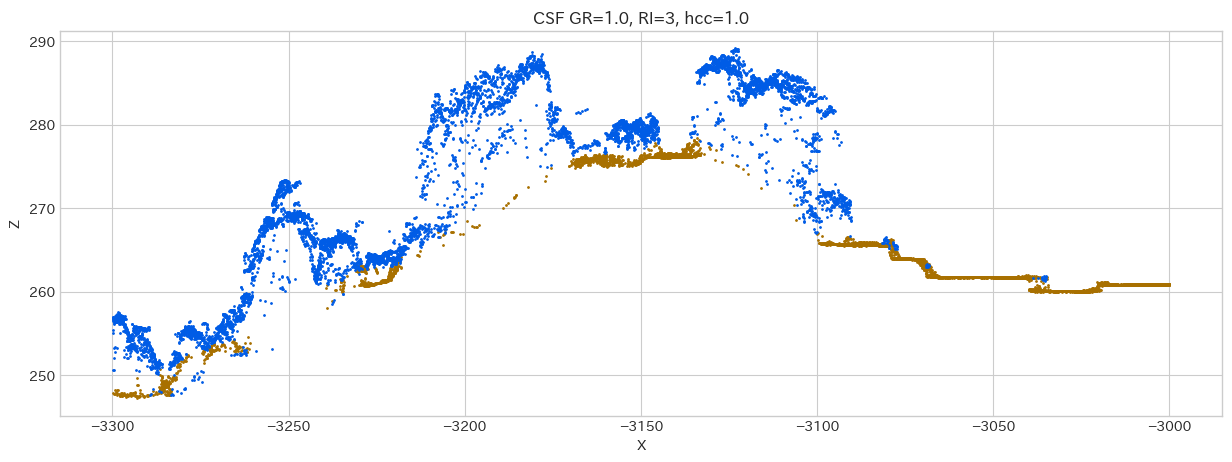

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(be_geoms.x, be_geoms.z, s=1, color='#A87000', label='BE（地表の点群）')
ax.scatter(obj_geoms.x, obj_geoms.z, s=1, c='#005CE6', label='OBJ（その他の点群）')
ax.set_title(f"CSF GR=1.0, RI=3, hcc=1.0")
ax.set_ylabel('Z')
ax.set_xlabel('X');

<br><br><br>

## **サンプルの切り抜き**
---
パラメーターを様々試して見たいですが、計算に時間が掛かるので、サンプルの範囲を適当に決め、その範囲の点群を別なファイルとして保存しましょう。

### **サンプル範囲の選定**

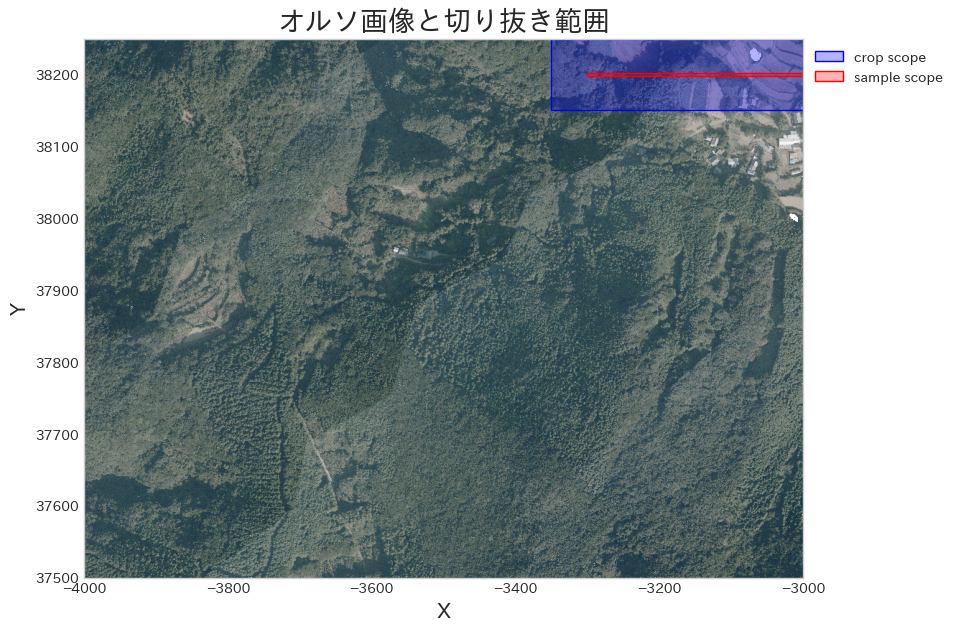

In [32]:
# 切り抜くデータの範囲を確認する
crop_scope = (
    shapely.LineString([
        [x_start - 50, y_max - 50],
        [x_end, y_max - 50]
    ])
    .buffer(50, cap_style='flat')
)

# オルソ画像を読み込む
ortho_path = r'../images/Ortho_RGB.png'
img_ary = plt.imread(ortho_path)

# 画像とサンプル範囲を重ねて表示
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(img_ary, extent=extent)
plot_polygon(crop_scope, ax=ax, add_points=False, 
             label='crop scope', color='blue')
plot_polygon(sample_scope, ax=ax, add_points=False, 
             label='sample scope', color='red')

ax.grid(False)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title('オルソ画像と切り抜き範囲', fontsize=20)
ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15)
ax.set_aspect('equal');

### **データの切り抜き**
データの切り抜きは pipeline のワークフローに "filters.crop" を追加して行います。

範囲は **"wkt（Well-known text : ベクター形式幾何学オブジェクトを文字列で表現するもの）"** で設定できるので、"shapely.Polygon.wkt" で範囲を示す Polygon の文字列を作成し渡しましょう。

In [20]:
SAMPLE_FILE_PATH = FILE_PATH.replace('proj', 'sample')

# データの切り抜き
workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': FILE_PATH
        },
        {
            'type': 'filters.crop',
            'polygon': crop_scope.wkt
        },
        {
            'type': 'writers.las',
            'filename': SAMPLE_FILE_PATH
        }
    ]
}

pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

308900

<br><br><br>
## **パラメーター変更による結果の確認**
---

### **処理のクラス化**
様々なパラメーターで試してみたい時に、毎度毎度コードを書くのは面倒で可読性が悪くなります。

全体の処理を関数化してしまいましょう。

In [21]:
class WorkFlow(object):
    def __init__(self, file_path: str, csf_dict: dict, sample_scope: shapely.Polygon):
        self.file_path = file_path
        self.csf_dict = csf_dict
        self.sample_scope = sample_scope
        self.pipeline = None
        self.be_geoms = None
        self.obj_geoms = None

    def execute(self):
        self._execute_pipeline()
        gdf = self._get_geodataframe()
        self.plot()

    @property
    def _json_workflow(self):
        workflow = {
            'pipeline': [
                {
                    'type': 'readers.las',
                    'filename': self.file_path
                },
                self.csf_dict
            ]
        }
        return json.dumps(workflow)
    
    def _execute_pipeline(self):
        pipeline = pdal.Pipeline(self._json_workflow)
        pipeline.execute()
        self.pipeline = pipeline

    def _get_geodataframe(self):
        if self.pipeline is None:
            return None
        df = self.pipeline.get_dataframe(0)
        geoms = gpd.points_from_xy(x=df['X'], y=df['Y'], z=df['Z'])
        gdf = gpd.GeoDataFrame(df, geometry=geoms, crs=IN_EPSG)
        select_gdf = gdf[gdf.intersects(self.sample_scope)].copy()
        self.obj_geoms = select_gdf[select_gdf['Classification'] == 1].geometry
        self.be_geoms = select_gdf[select_gdf['Classification'] == 2].geometry
        return gdf

    @property
    def _get_title(self):
        title = "CSF parameter - {"
        title += f"GR: {self.csf_dict.get('resolution')},  "
        title += f"RI: {self.csf_dict.get('rigidness')},  "
        title += f"Threshold: {self.csf_dict.get('threshold')}"
        title += "}"
        return title

    def plot(self, figsize=(15, 5), be_size=3, title=None, save=None):
        if title is None:
            title = self._get_title
        if self.be_geoms is None:
            return None
        fig, ax = plt.subplots(figsize=figsize)
        ax.scatter(
            self.be_geoms.x, self.be_geoms.z, s=be_size, 
            color='#A87000', 
            label=f"BE（地表の点群）: {'{:,}'.format(len(self.be_geoms))}"
        )
        ax.scatter(
            self.obj_geoms.x, self.obj_geoms.z, s=1, 
            c='#005CE6', label=f"OBJ（その他の点群）: {'{:,}'.format(len(self.obj_geoms))}"
        )
        ax.set_title(title, fontsize=17)
        ax.set_ylabel('Z')
        ax.set_xlabel('X')
        ax.legend(fontsize=12)
        if save is None:
            plt.show()
        else:
            plt.savefig(save, dpi=500)

### **Grid Particleの解像度による結果の違い**
まずは最も重要そうな **GR(Grid Resolution : 解像度)** の違いにより、どのように結果が変化していくのかを試してみます。

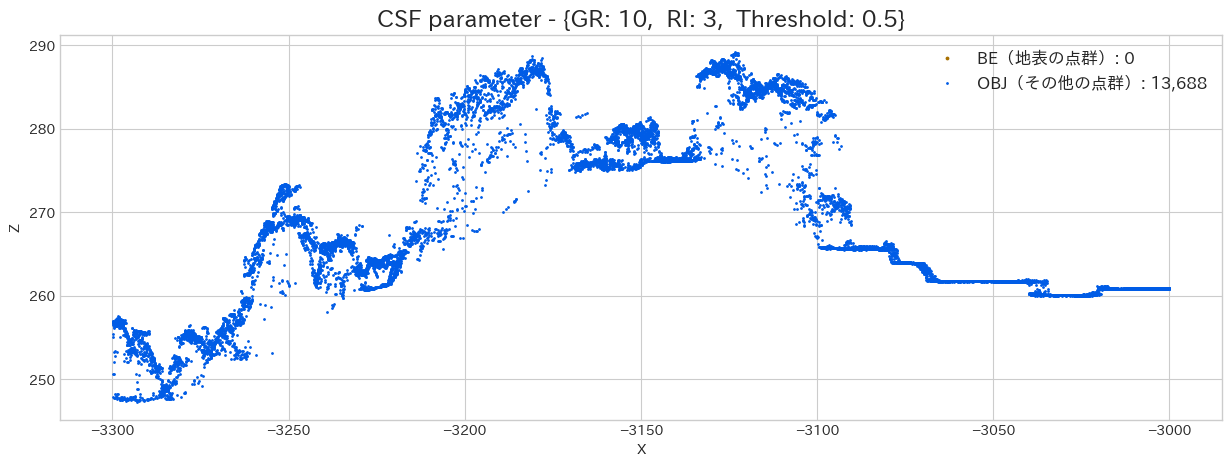

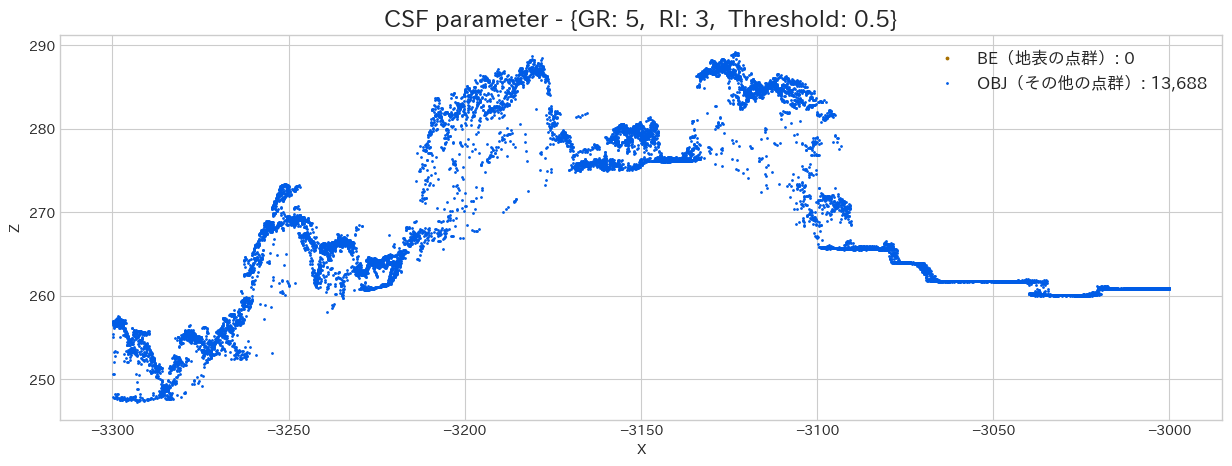

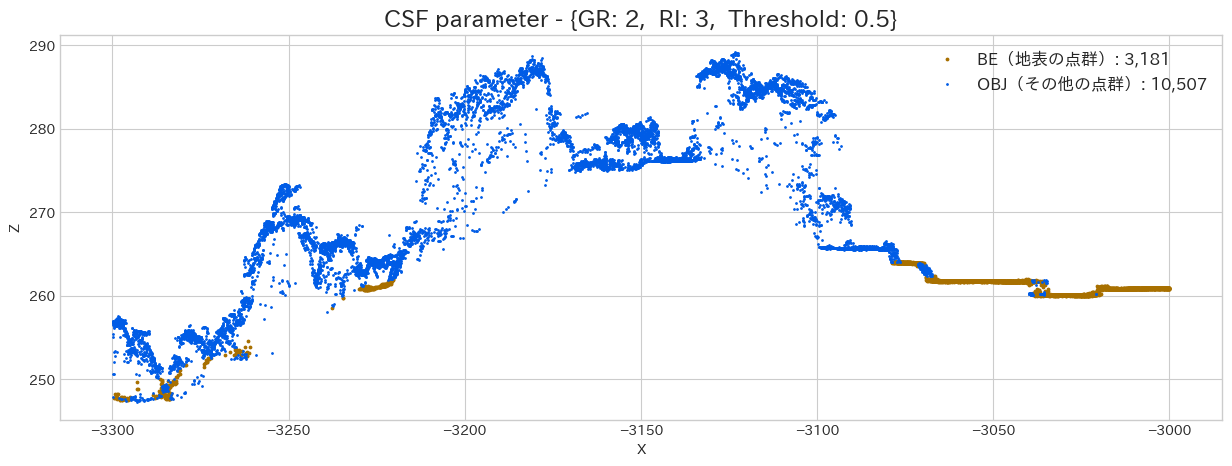

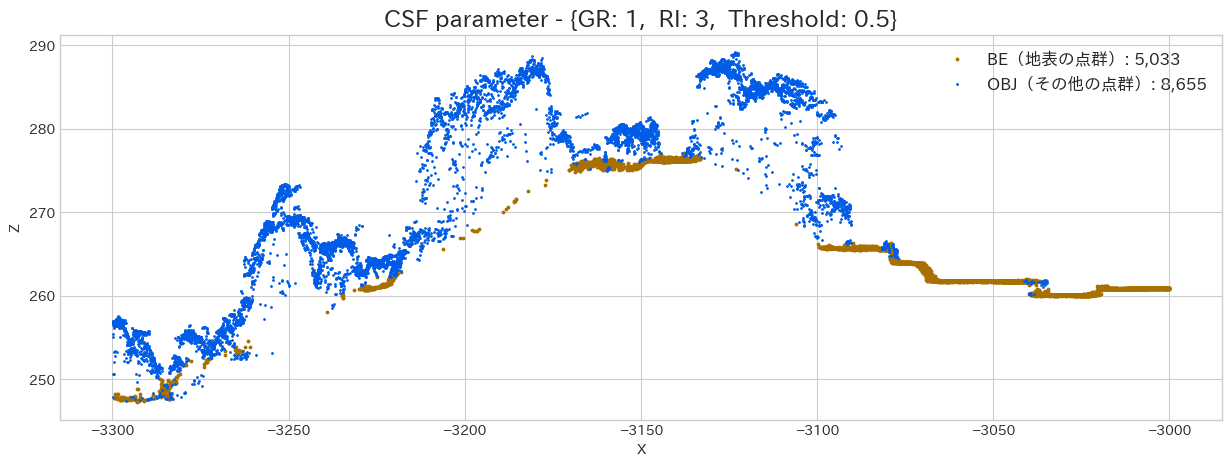

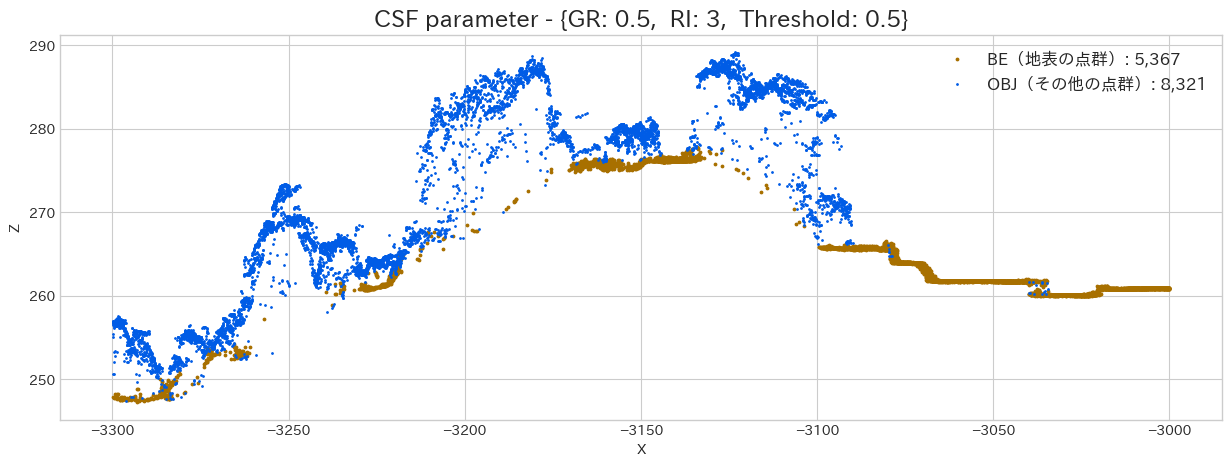

In [22]:
# CSFのパラメーター設定
csf_dict = {
    'type': 'filters.csf',
    # Grid Resolution = 1m（デフォルトも1.0なので本当は不要）
    'resolution': None,
    # Rigidness = 3（デフォルトも3なので本当は不要）
    'rigidness': 3,
    # Threshold(hcc) = 0.5（デフォルトも0.5なので本当は不要）
    'threshold': 0.5
}

resolution_lst = [10, 5, 2, 1, 0.5]
for gr in resolution_lst:
    csf_dict['resolution'] = gr
    wf = WorkFlow(SAMPLE_FILE_PATH, csf_dict, sample_scope)
    wf.execute()

上記で出力した散布図を見ると、GRが小さい程、それなりに地面をキレイに分類出来ている様に思えます。

しかし、小さすぎると上手く対応できていない部分もあるように思えますし、計算時間が長くなるので、これはデータを見ながら **[1.0, 0.5]** などで調整してあげるといいかもしれません。

### **Rigidnessによる結果の違い**
次はRigidness（Particle 間を結合している線の剛性）を調整してみましょう。Grid Particle は $GR=0.5$ にしておきます。

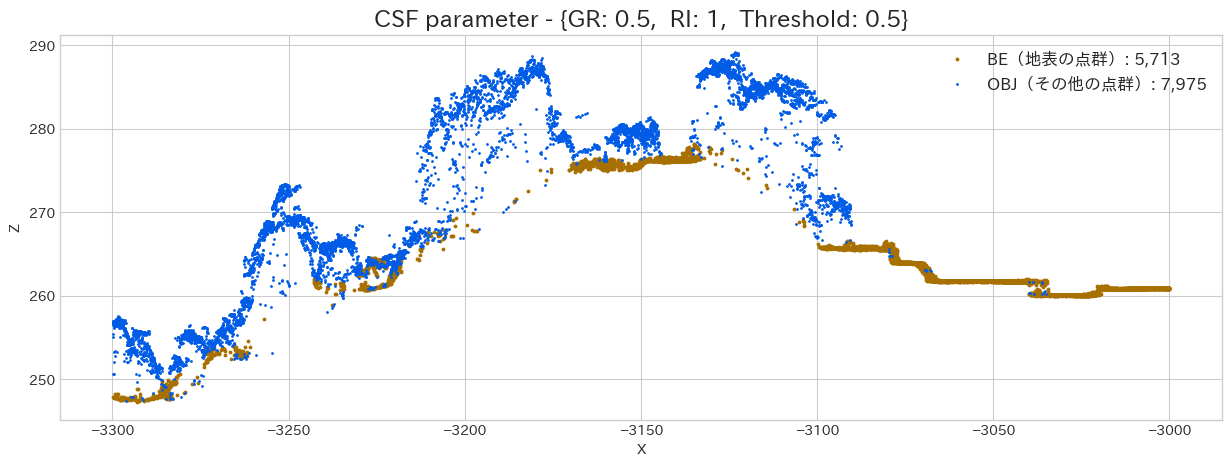

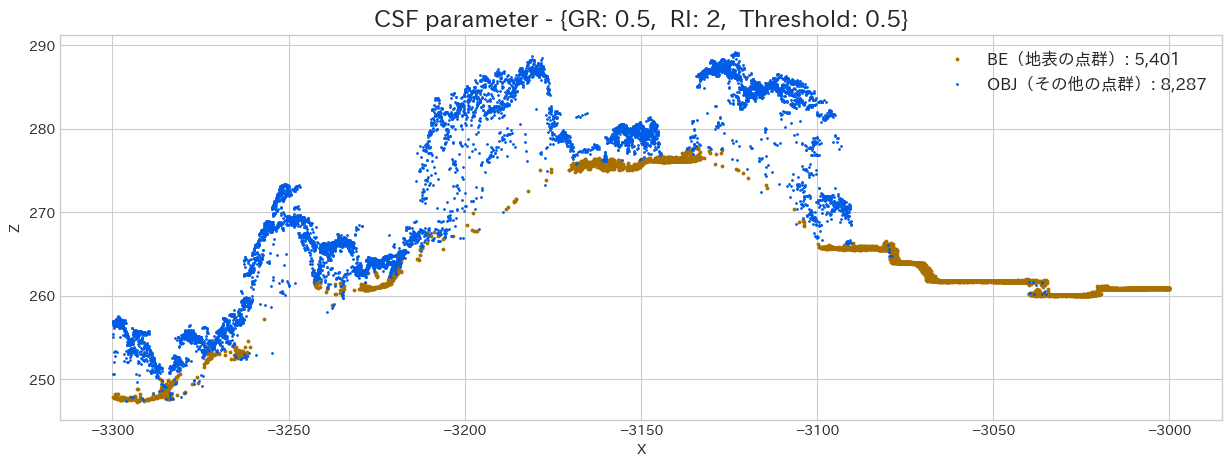

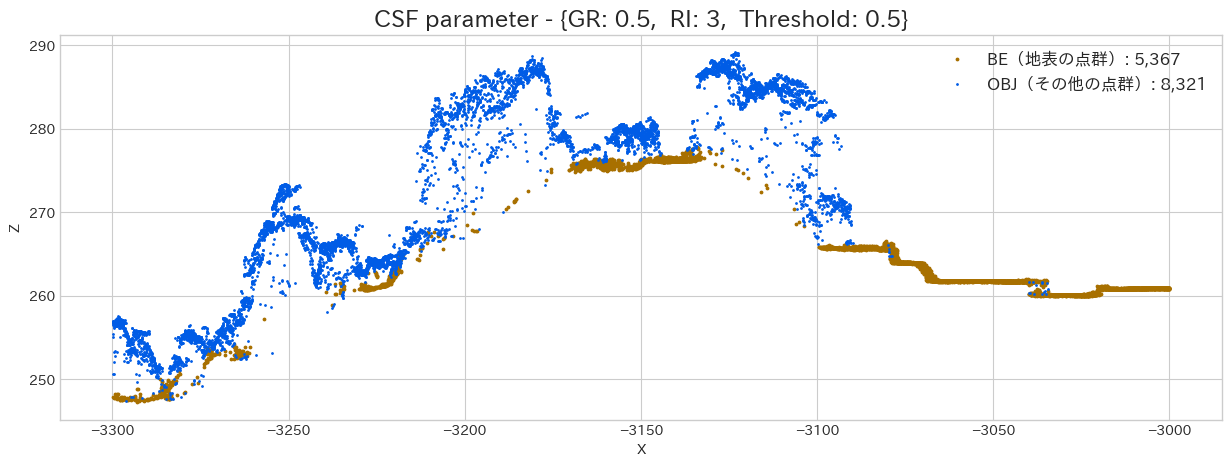

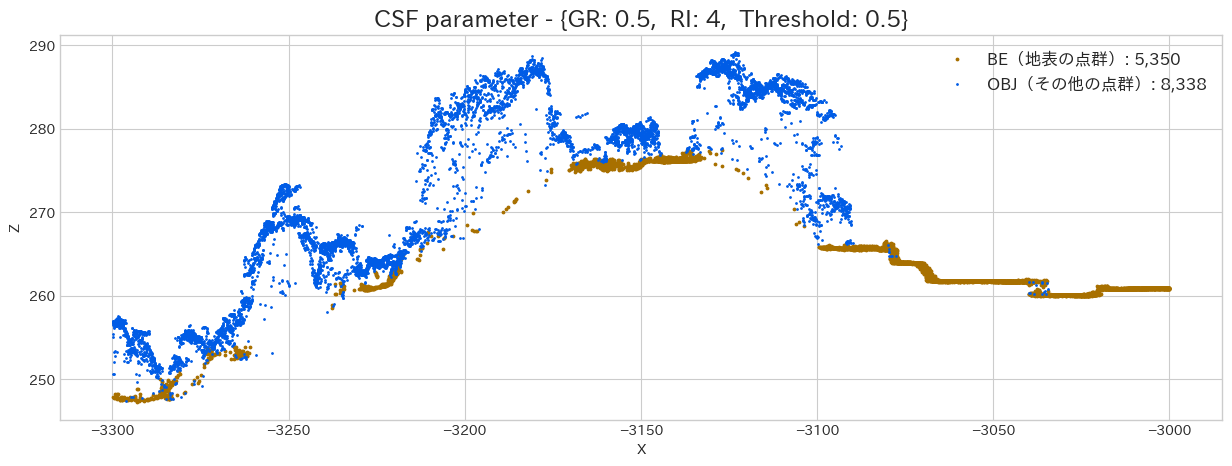

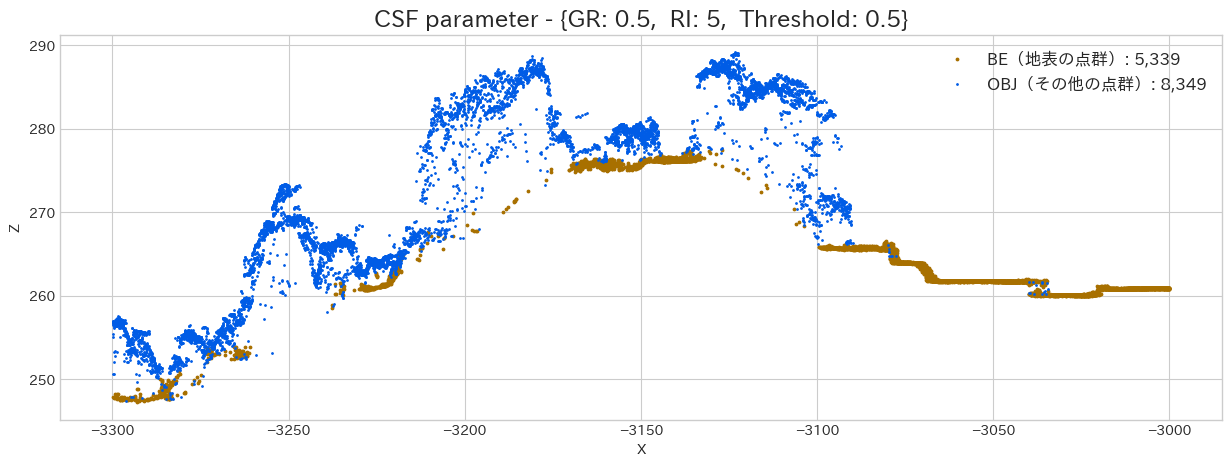

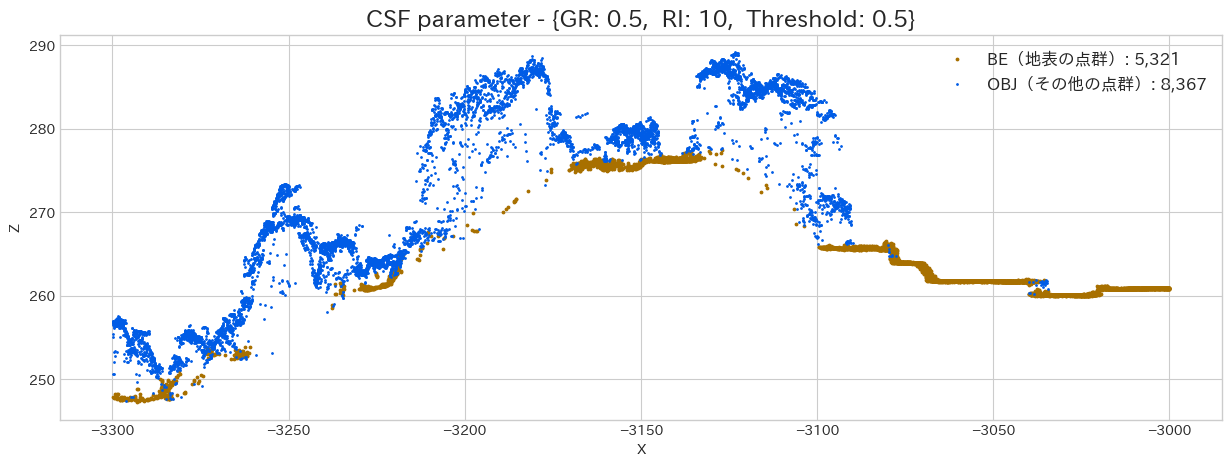

In [23]:
# CSFのパラメーター設定
csf_dict = {
    'type': 'filters.csf',
    'resolution': 0.5,
    'rigidness': None,
    'threshold': 0.5
}

rigidness_lst = [1, 2, 3, 4, 5, 10]
for rigidness in rigidness_lst:
    csf_dict['rigidness'] = rigidness
    wf = WorkFlow(SAMPLE_FILE_PATH, csf_dict, sample_scope)
    wf.execute()

やはり Rigidness は大きくした方が、綺麗に地表点を分類出来ています。しかし、急斜面であれば、固くしすぎると地面を追従出来ないので注意が必要です。この程度の傾斜であればデフォルトのままで大丈夫でしょう。

例えば調査箇所の一部が急斜面であるならば、複数のデータに切り分けてこの処理を行うというのも手かもしれません。


### **Threshold（hcc）による結果の違い**
Threshold を変更する事で、地面と分類する点群データを増やす事が出来ます。最終的に DTM を作成する場合はセル内の最小値を使用したりするので、今回はこの閾値を上げて見ましょう。

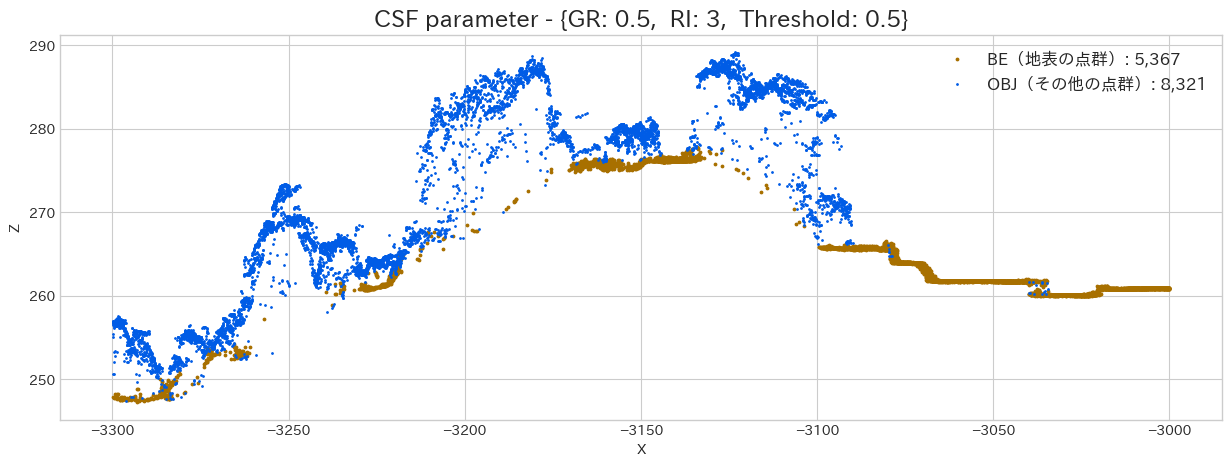

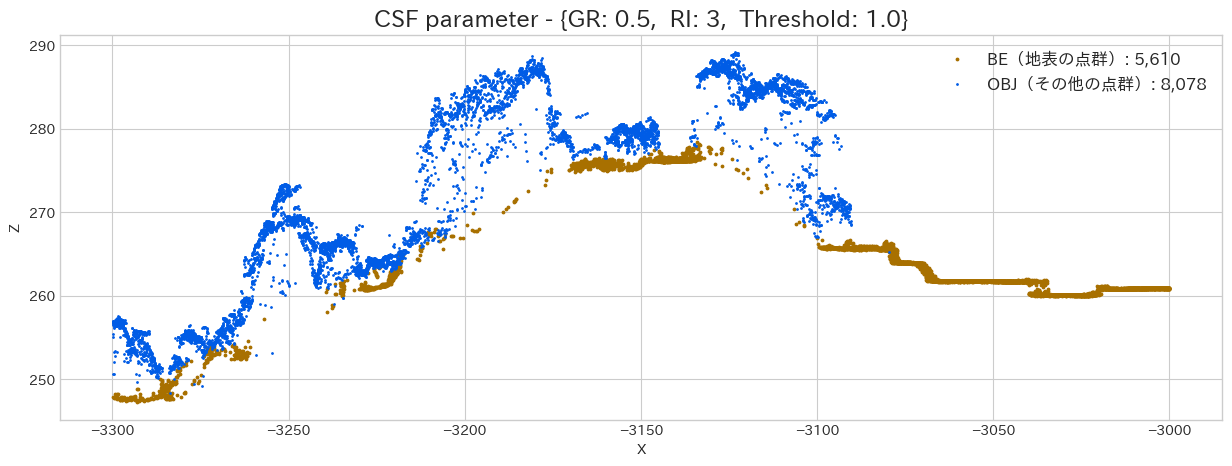

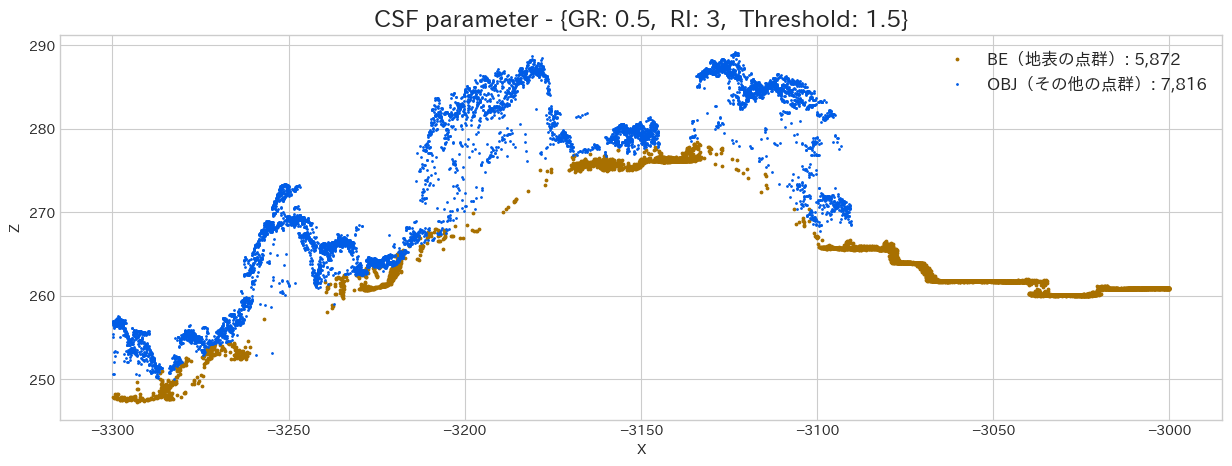

In [24]:
# CSFのパラメーター設定
csf_dict = {
    'type': 'filters.csf',
    # Grid Resolution = 1m（デフォルトも1.0なので本当は不要）
    'resolution': 0.5,
    # Rigidness = 3（デフォルトも3なので本当は不要）
    'rigidness': 3,
    # Threshold(hcc) = 0.5（デフォルトも0.5なので本当は不要）
    'threshold': None
}

hcc_lst = [0.5, 1.0, 1.5]
for hcc in hcc_lst:
    csf_dict['threshold'] = hcc
    wf = WorkFlow(SAMPLE_FILE_PATH, csf_dict, sample_scope)
    wf.execute()

Threshold に関しては、市街地や畑（サンプル右側）であれば、$threshold=0.5$ でよさそうですが、森林などを測る場合は $threshold=1.0$ でもいいかもしれません。


<br><br><br>

## **DTM の作成**
---
ここまでで、点群の分類方法を学んできました。最後にこの分類した点群データの中から、地表点のみを抽出し、DTM に変換して出力してみましょう。

In [25]:
# 結構時間が掛かります
DTM_PATH =  FILE_PATH.replace('proj.las', 'DTM_R05.tif')

workflow = {
    'pipeline': [
        {
            # データの読み込み
            'type': 'readers.las',
            'filename': FILE_PATH
        },
        {
            # CSF の実行
            'type': 'filters.csf',
            'resolution': 0.5,
            'rigidness': 3,
            'threshold': 1.0
        },
        {
            # 条件式を使用して、地表点のみを抽出する
            'type': 'filters.expression',
            'expression': 'Classification == 2'
        },
        {
            # GDALを使用して、Tiff として出力
            'type': 'writers.gdal',
            # 出力先
            'filename': DTM_PATH,
            # 出力するデータの空間参照系
            'default_srs': IN_SRS,
            # セルサイズ（地上分解能）
            'resolution':0.5,
            # セルの中心から半径を指定して、セル値（高さ）の計算に使用する。
            # 設定した半径内の地表点群を使用してセル値を求める
            # デフォルトは "0.71m = 地上分解能 × squrt(2) = 0.5 × 1.4142"
            'radius': 1.0,
            # Fallback内挿法を適用する場合の、ターゲットセルまでの最大セル数
            'window_size': 8,
            'output_type': 'min',
            'gdaldriver':'GTiff',
        }
    ]
}
pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

830379

## おわりに
----
ここまでで、CSF を使用した点群分類や、DTMの作成（出力）について学んできました。次は DSM の作成について解説したいところですが、その前に出力した DTM を読み込んで確認してみましょう。

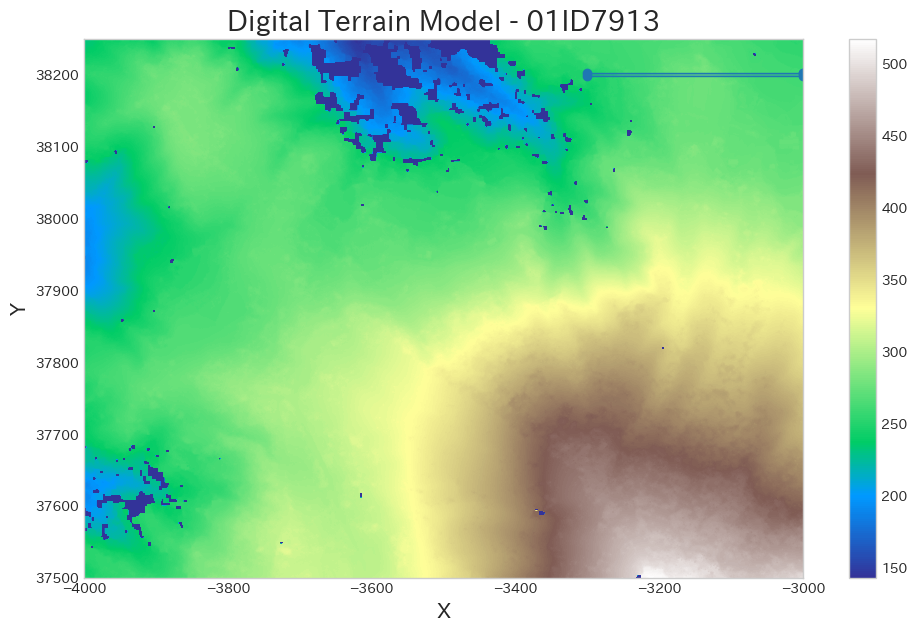

In [34]:
ds = rasterio.open(DTM_PATH)
dtm_org = ds.read()[0]
# 欠損した場所が色に影響を与えるので最小値を設定する
z_min = np.min(dtm_org[0 <= dtm_org])

plt.figure(figsize=(12, 7))
plt.imshow(dtm_org, vmin=z_min, cmap='terrain', extent=extent)
plt.colorbar()
plt.title('Digital Terrain Model - 01ID7913', fontsize=20)
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.grid(False);
# plt.savefig(r'../images/dtm_img.jpg', dpi=500)

上記を見ると、ポツポツと穴（欠損）があるのが確認できます。これは DTM を作成する際に 'window_size' で指定したセルでも補完が効かなかった場所を表しています。

CSF での分類の最後に示した画像を見て下さい。$X=-3250$ の辺りは**地表点と分類された計測データはありませんでした**。この地表点がなかった場所が穴になっているのです。また、よく見ると（白い部分など）ボコボコしている部分があります。この場所は森林になっていたので、地表付近に背の低い何らかの植物があったのかもしれません。

このままではキレイなDTMになっているとは言えません。

次回は、この欠損を穴埋めし、データを少し滑らかにしようと思います。

## 参考
---

[An Easy-to-Use Airborne LiDAR Data Filtering Method Based on Cloth Simulation](https://www.mdpi.com/2072-4292/8/6/501)

[Well-known text - Wikipedia](https://ja.wikipedia.org/wiki/Well-known_text)

[cloud-cloud distance](https://www.cloudcompare.org/doc/wiki/index.php?title=Distances_Computation)

[PDAL filters.expression](https://pdal.io/en/2.7-maintenance/stages/filters.expression.html#filters-expression)

[PDAL filters.gdal](https://pdal.io/en/2.7-maintenance/stages/writers.gdal.html#writers-gdal)

[PDAL Generating a DTM](https://pdal.io/en/2.4.3/workshop/exercises/analysis/dtm/dtm.html)